In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import numpy as np
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001

# MNIST dataset with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Improved CKN implementation
def extract_patches(x, kernel_size, stride):
    B, C, H, W = x.shape
    patches = x.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
    patches = patches.contiguous().view(B, C, -1, kernel_size, kernel_size)
    patches = patches.permute(0, 2, 3, 4, 1).contiguous()
    patches = patches.view(-1, kernel_size * kernel_size * C)
    return patches

def normalize_patches(patches):
    mean = patches.mean(dim=1, keepdim=True)
    patches -= mean
    norm = torch.norm(patches, p=2, dim=1, keepdim=True)
    norm = torch.clamp(norm, min=1e-6)
    return patches / norm

class CKNNLayer(nn.Module):
    def __init__(self, in_channels, kernel_size, stride, num_filters, pool_size, pool_stride, gamma=1.0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.num_filters = num_filters
        self.pool = nn.AvgPool2d(pool_size, stride=pool_stride)
        self.gamma = gamma
        self.in_channels = in_channels
        self.register_buffer('filters', None)

    def set_filters(self, filters):
        self.filters = filters

    def forward(self, x):
        B, C, H, W = x.shape

        # Extract and normalize patches
        patches = extract_patches(x, self.kernel_size, self.stride)
        patches = normalize_patches(patches)

        # Compute Gaussian kernel activations
        filters = self.filters.view(self.num_filters, -1)
        distances = torch.cdist(patches, filters, p=2)
        activations = torch.exp(-self.gamma * distances**2)

        # Reshape and pool
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1
        activations = activations.view(B, H_out, W_out, self.num_filters).permute(0, 3, 1, 2)
        return self.pool(activations)

class CKN(nn.Module):
    def __init__(self, layer_specs, num_classes):
        super().__init__()
        self.layers = nn.ModuleList()
        in_channels = 1  # MNIST has 1 input channel

        for spec in layer_specs:
            self.layers.append(
                CKNNLayer(
                    in_channels=in_channels,
                    kernel_size=spec['kernel_size'],
                    stride=spec['stride'],
                    num_filters=spec['num_filters'],
                    pool_size=spec['pool_size'],
                    pool_stride=spec['pool_stride'],
                    gamma=spec['gamma']
                )
            )
            in_channels = spec['num_filters']

        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(128 * 5 * 5, 256),  # Adjusted to match the shape
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(256, num_classes)
        )


    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.classifier(x)

def train_ckn_layers(model, train_loader, device):
    model.eval()
    prev_outputs = []
    for i, layer in enumerate(model.layers):
        print(f"Training layer {i+1}/{len(model.layers)}...")
        start_time = time.time()

        # Collect inputs for the current layer
        if i == 0:
            inputs = []
            for images, _ in train_loader:
                inputs.append(images.to(device))
            inputs = torch.cat(inputs, dim=0)
        else:
            inputs = prev_outputs

        # Extract and normalize patches (with subsampling)
        patches_list = []
        for batch in inputs.chunk(100):
            patches = extract_patches(batch, layer.kernel_size, layer.stride)
            patches = normalize_patches(patches)
            patches_list.append(patches.cpu().numpy())

        all_patches = np.concatenate(patches_list, axis=0)

        # Subsample patches for faster clustering
        n_samples = min(100000, all_patches.shape[0])
        all_patches = all_patches[np.random.choice(all_patches.shape[0], n_samples, replace=False)]

        # K-means clustering
        kmeans = KMeans(n_clusters=layer.num_filters, random_state=0, n_init=10)
        kmeans.fit(all_patches)
        filters = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=device)
        layer.set_filters(filters)

        # Update prev_outputs for next layer
        with torch.no_grad():
            prev_outputs = []
            for batch in inputs.chunk(100):
                prev_outputs.append(layer(batch))
            prev_outputs = torch.cat(prev_outputs, dim=0)

        print(f"Layer {i+1} trained in {time.time()-start_time:.2f}s")

    model.train()

# Model configuration for MNIST
layer_specs = [
    {
        'kernel_size': 5,
        'stride': 1,
        'num_filters': 64,
        'pool_size': 2,
        'pool_stride': 2,
        'gamma': 0.5
    },
    {
        'kernel_size': 3,
        'stride': 1,
        'num_filters': 128,
        'pool_size': 2,
        'pool_stride': 2,
        'gamma': 0.5
    }
]

model = CKN(layer_specs, num_classes=10).to(device)

# Train filters layer-wise
print("Training CKN filters...")
train_ckn_layers(model, train_loader, device)

# Train classifier
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Training loop
total_step = len(train_loader)
print("Starting classifier training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

    # Update learning rate
    scheduler.step(running_loss/total_step)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Training CKN filters...
Training layer 1/2...
Layer 1 trained in 28.87s
Training layer 2/2...
Layer 2 trained in 300.15s
Starting classifier training...
Epoch [1/10], Step [100/469], Loss: 1.5557
Epoch [1/10], Step [200/469], Loss: 1.2046
Epoch [1/10], Step [300/469], Loss: 1.1154
Epoch [1/10], Step [400/469], Loss: 0.8372
Epoch [2/10], Step [100/469], Loss: 0.8864
Epoch [2/10], Step [200/469], Loss: 0.7095
Epoch [2/10], Step [300/469], Loss: 0.7824
Epoch [2/10], Step [400/469], Loss: 0.6054
Epoch [3/10], Step [100/469], Loss: 0.6836
Epoch [3/10], Step [200/469], Loss: 0.5971
Epoch [3/10], Step [300/469], Loss: 0.6909
Epoch [3/10], Step [400/469], Loss: 0.6636
Epoch [4/10], Step [100/469], Loss: 0.6569
Epoch [4/10], Step [200/469], Loss: 0.5645
Epoch [4/10], Step [300/469], Loss: 0.6333
Epoch [4/10], Step [400/469], Loss: 0.3906
Epoch [5/10], Step [100/469], Loss: 0.5989
Epoch [5/10], Step [200/469], Loss: 0.5120
Epoch [5/10], Step [300/469], Loss: 0.5541
Epoch [5/10], Step [400/469], 

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import numpy as np
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001

# CIFAR-10 dataset with normalization
# You can add augmentations like RandomCrop and RandomHorizontalFlip for better performance.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform_train,
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform_test,
    download=True
)

# Data loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# -------------- CKN Implementation --------------

def extract_patches(x, kernel_size, stride):
    """
    x: B x C x H x W
    Return: (B * number_of_patches) x (kernel_size*kernel_size*C)
    """
    B, C, H, W = x.shape
    patches = x.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
    patches = patches.contiguous().view(B, C, -1, kernel_size, kernel_size)
    # Move patch dimension forward and flatten
    patches = patches.permute(0, 2, 3, 4, 1).contiguous()
    patches = patches.view(-1, kernel_size * kernel_size * C)
    return patches

def normalize_patches(patches):
    """
    Subtract mean and divide by norm for each patch.
    """
    mean = patches.mean(dim=1, keepdim=True)
    patches -= mean
    norm = torch.norm(patches, p=2, dim=1, keepdim=True)
    norm = torch.clamp(norm, min=1e-6)
    return patches / norm

class CKNNLayer(nn.Module):
    def __init__(self, in_channels, kernel_size, stride, num_filters,
                 pool_size, pool_stride, gamma=1.0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.num_filters = num_filters
        self.pool = nn.AvgPool2d(pool_size, stride=pool_stride)
        self.gamma = gamma
        self.in_channels = in_channels
        # We'll store the filters in a buffer so they're not trainable via backprop
        self.register_buffer('filters', None)

    def set_filters(self, filters):
        # K-means centroids become our filters
        self.filters = filters

    def forward(self, x):
        B, C, H, W = x.shape

        # Extract and normalize patches
        patches = extract_patches(x, self.kernel_size, self.stride)
        patches = normalize_patches(patches)

        # Compute Gaussian kernel activations
        filters = self.filters.view(self.num_filters, -1)  # (num_filters, D)
        distances = torch.cdist(patches, filters, p=2)     # (B*patches, num_filters)
        activations = torch.exp(-self.gamma * distances**2)

        # Reshape to (B, num_filters, H_out, W_out)
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1

        activations = activations.view(B, H_out, W_out, self.num_filters)
        activations = activations.permute(0, 3, 1, 2)  # (B, num_filters, H_out, W_out)

        # Average Pool
        return self.pool(activations)

class CKN(nn.Module):
    def __init__(self, layer_specs, num_classes):
        super().__init__()
        self.layers = nn.ModuleList()

        # CIFAR-10 => 3 input channels
        in_channels = 3

        for spec in layer_specs:
            self.layers.append(
                CKNNLayer(
                    in_channels=in_channels,
                    kernel_size=spec['kernel_size'],
                    stride=spec['stride'],
                    num_filters=spec['num_filters'],
                    pool_size=spec['pool_size'],
                    pool_stride=spec['pool_stride'],
                    gamma=spec['gamma']
                )
            )
            in_channels = spec['num_filters']

        # After two layers (with the specs below) we get 128 x 6 x 6 on CIFAR-10
        # => 128 * 6 * 6 = 4608
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(256*2*2, 512),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(512, num_classes)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.classifier(x)

def train_ckn_layers(model, train_loader, device):
    """
    Layer-wise "pretraining":
    1) Collect feature maps (or raw images for first layer).
    2) Extract patches & normalize.
    3) Cluster patches to get filters (K-means).
    4) Set layer filters.
    5) Pass data through layer to feed next layer.
    """
    model.eval()
    prev_outputs = []

    for i, layer in enumerate(model.layers):
        print(f"Training layer {i+1}/{len(model.layers)}...")
        start_time = time.time()

        # Collect inputs for this layer
        if i == 0:
            # For the first layer, the input is just the original images
            inputs = []
            for images, _ in train_loader:
                inputs.append(images.to(device))
            inputs = torch.cat(inputs, dim=0)
        else:
            # For subsequent layers, use outputs of the previous layer
            inputs = prev_outputs

        # Extract and normalize patches (with subsampling to keep it manageable)
        patches_list = []
        # Chunk the data to avoid OOM
        for batch in inputs.split(100):
            patches = extract_patches(batch, layer.kernel_size, layer.stride)
            patches = normalize_patches(patches)
            patches_list.append(patches.cpu().numpy())  # move to CPU for k-means
        all_patches = np.concatenate(patches_list, axis=0)

        # Subsample patches for clustering
        n_samples = min(100_000, all_patches.shape[0])
        idx = np.random.choice(all_patches.shape[0], n_samples, replace=False)
        sample_patches = all_patches[idx]

        # K-means clustering => cluster_centers_ as filters
        kmeans = KMeans(n_clusters=layer.num_filters, random_state=0, n_init=10)
        kmeans.fit(sample_patches)
        filters = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=device)
        layer.set_filters(filters)

        # Compute output of this layer for all data => feed into next layer
        with torch.no_grad():
            outputs_list = []
            for batch in inputs.split(100):
                outputs_list.append(layer(batch))
            prev_outputs = torch.cat(outputs_list, dim=0)

        print(f"Layer {i+1} trained in {time.time()-start_time:.2f}s")

    model.train()

# -------------- Model Configuration --------------

layer_specs = [
    {
        'kernel_size': 5,
        'stride': 1,
        'num_filters': 64,
        'pool_size': 2,
        'pool_stride': 2,
        'gamma': 0.5
    },
    {
        'kernel_size': 3,
        'stride': 1,
        'num_filters': 128,
        'pool_size': 2,
        'pool_stride': 2,
        'gamma': 0.5
    },
    {
        'kernel_size': 3,
        'stride': 1,
        'num_filters': 256,
        'pool_size': 2,
        'pool_stride': 2,
        'gamma': 0.5
    }
]

model = CKN(layer_specs, num_classes=10).to(device)

# -------------- Train the filters layer-wise --------------

print("Training CKN filters...")
train_ckn_layers(model, train_loader, device)

# -------------- Train the classifier --------------

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

print("Starting classifier training...")
total_step = len(train_loader)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

    # Update learning rate based on epoch loss
    scheduler.step(running_loss / total_step)

# -------------- Test the model --------------

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy on CIFAR-10: {100 * correct / total:.2f}%')


Files already downloaded and verified
Files already downloaded and verified
Training CKN filters...
Training layer 1/3...
Layer 1 trained in 56.39s
Training layer 2/3...
Layer 2 trained in 351.11s
Training layer 3/3...
Layer 3 trained in 1176.07s
Starting classifier training...
Epoch [1/10], Step [100/391], Loss: 2.1279
Epoch [1/10], Step [200/391], Loss: 2.0918
Epoch [1/10], Step [300/391], Loss: 2.0386
Epoch [2/10], Step [100/391], Loss: 2.0347
Epoch [2/10], Step [200/391], Loss: 2.0062
Epoch [2/10], Step [300/391], Loss: 2.0581
Epoch [3/10], Step [100/391], Loss: 2.0168
Epoch [3/10], Step [200/391], Loss: 1.9910
Epoch [3/10], Step [300/391], Loss: 2.0200
Epoch [4/10], Step [100/391], Loss: 2.0512
Epoch [4/10], Step [200/391], Loss: 2.0226
Epoch [4/10], Step [300/391], Loss: 2.0019
Epoch [5/10], Step [100/391], Loss: 1.9796
Epoch [5/10], Step [200/391], Loss: 2.0247
Epoch [5/10], Step [300/391], Loss: 1.9065
Epoch [6/10], Step [100/391], Loss: 2.0561
Epoch [6/10], Step [200/391], Los

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import random

# For datasets and data loading
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# For numeric stability, etc.
torch.set_default_dtype(torch.float32)


In [ ]:
def extract_random_patches(dataset,
                           num_patches=50000,
                           patch_size=3):
    """
    Extract random patches from images in a dataset.

    Args:
        dataset: A PyTorch dataset (each sample is (C, H, W)).
        num_patches: How many patches to extract in total.
        patch_size: Spatial size of the square patch (e.g. 3).

    Returns:
        patches: A numpy array of shape (num_patches, C*patch_size*patch_size).
    """
    # We'll accumulate patches here
    all_patches = []

    # Number of patches extracted so far
    extracted = 0

    # Randomly sample from dataset
    while extracted < num_patches:
        i = random.randint(0, len(dataset) - 1)
        img, _ = dataset[i]  # (C, H, W), float tensor in [0,1]

        # Convert to numpy if needed
        img_np = img.numpy()

        # Random location for the patch
        H, W = img_np.shape[1], img_np.shape[2]
        y = random.randint(0, H - patch_size)
        x = random.randint(0, W - patch_size)

        patch = img_np[:, y:y+patch_size, x:x+patch_size].reshape(-1)
        all_patches.append(patch)
        extracted += 1

    patches = np.array(all_patches, dtype=np.float32)
    return patches


In [ ]:
def spherical_kmeans(X, num_clusters, max_iter=100, tol=1e-4, verbose=False):
    """
    Perform spherical k-means clustering on data X.

    Args:
        X: numpy array of shape (N, D) with rows as data points.
        num_clusters: number of clusters (dictionary size).
        max_iter: max iterations.
        tol: convergence tolerance.
        verbose: whether to print debug info.

    Returns:
        centers: numpy array of shape (num_clusters, D), each row is a center on the unit sphere.
    """
    N, D = X.shape

    # Random init of cluster centers
    indices = np.random.choice(N, num_clusters, replace=False)
    centers = X[indices]

    # Normalize centers to unit norm
    centers = centers / (np.linalg.norm(centers, axis=1, keepdims=True) + 1e-12)

    for it in range(max_iter):
        # Compute cosine similarities
        # shape: (N, num_clusters)
        similarities = X @ centers.T

        # Assign each sample to the closest center (highest cosine similarity)
        labels = np.argmax(similarities, axis=1)

        # Recompute centers
        new_centers = np.zeros_like(centers)
        count = np.zeros(num_clusters, dtype=np.int32)

        for i in range(N):
            new_centers[labels[i]] += X[i]
            count[labels[i]] += 1

        # Avoid division by zero
        for c in range(num_clusters):
            if count[c] > 0:
                new_centers[c] /= count[c]

        # Re-normalize to sphere
        norms = np.linalg.norm(new_centers, axis=1, keepdims=True) + 1e-12
        new_centers = new_centers / norms

        # Check for convergence
        shift = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if verbose:
            print(f"[SphericalKMeans Iter {it}] shift={shift:.6f}")
        if shift < tol:
            break

    return centers


In [ ]:
def create_gaussian_kernel_2d(ksize=3, sigma=1.0):
    """
    Creates a 2D Gaussian kernel of size ksize x ksize with std=sigma.
    Returns a PyTorch tensor of shape (1, 1, ksize, ksize).
    """
    ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
    xx = ax.repeat(ksize, 1)
    yy = xx.t()
    kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    kernel = kernel / kernel.sum()
    return kernel.view(1, 1, ksize, ksize)

class GaussianPool2D(nn.Module):
    """
    Gaussian Pooling: convolve with a fixed Gaussian kernel, then subsample.
    """
    def __init__(self, kernel_size=3, sigma=1.0, stride=2):
        super().__init__()
        self.stride = stride
        gk = create_gaussian_kernel_2d(ksize=kernel_size, sigma=sigma)
        # Register as buffer so it’s not a learnable parameter, but moves to cuda if needed
        self.register_buffer('gk', gk)

    def forward(self, x):
        # x shape: (B, C, H, W)
        B, C, H, W = x.shape
        # Convolve per-channel: group convolution trick
        # We'll expand gk to (C, 1, kH, kW), then use groups=C in F.conv2d
        gk = self.gk.expand(C, 1, -1, -1)
        x = F.conv2d(x, gk, stride=self.stride, padding=1, groups=C)
        # shape is now (B, C, H_out, W_out)
        return x


In [ ]:
class CKNLayer(nn.Module):
    def __init__(self,
                 in_channels,      # e.g. 3 for RGB, or #filters from previous layer
                 patch_size=3,
                 num_filters=32,   # p
                 alpha=10.0,       # kernel param
                 pool_ksize=3,
                 pool_sigma=1.0,
                 pool_stride=2):
        """
        A single CKN layer with:
          - Learned dictionary Z (num_filters x (in_channels*patch_size^2))
          - Precomputed or learned M = [kappa_1(Z^T Z)]^{-1/2}
          - Gaussian pooling
        """
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.num_filters = num_filters
        self.alpha = nn.Parameter(torch.tensor(alpha), requires_grad=True)

        # Z: shape (num_filters, in_channels*patch_size*patch_size)
        # We'll init this after spherical k-means externally, or random
        D = in_channels * patch_size * patch_size
        self.Z = nn.Parameter(torch.randn(num_filters, D), requires_grad=True)

        # M: shape (num_filters, num_filters)
        # We'll initialize to identity; eventually we’ll update it after we set Z
        M_init = torch.eye(num_filters)
        self.M = nn.Parameter(M_init, requires_grad=True)

        # Gaussian pooling
        self.pool = GaussianPool2D(kernel_size=pool_ksize, sigma=pool_sigma, stride=pool_stride)

    def forward(self, x):
        """
        Forward pass:
        x: (B, in_channels, H, W)

        Steps:
          1) Extract patches via F.unfold
          2) Normalize patches
          3) Dot with Z^T
          4) Apply kernel kappa_1(t) = exp(alpha * (t-1))
          5) Multiply by M
          6) Reshape -> (B, num_filters, H_out, W_out)
          7) Gaussian pooling
        """
        B, C, H, W = x.shape
        p = self.patch_size

        # 1) Extract patches: shape after unfold is (B, C*p*p, L)
        # where L = H_out * W_out if stride=1, padding=0
        patches = F.unfold(x, kernel_size=p, padding=0, stride=1)  # shape (B, C*p*p, H_sub*W_sub)

        # The spatial size after unfold
        # For simplicity, assume no padding, stride=1 => output size = (H-p+1)*(W-p+1)
        H_sub = H - p + 1
        W_sub = W - p + 1

        # 2) Normalize each patch
        # patches: (B, D, L) where D = C*p*p
        patches = patches.permute(0, 2, 1)  # (B, L, D)
        # Norm
        patch_norms = torch.norm(patches, dim=2, keepdim=True) + 1e-12
        patches_normalized = patches / patch_norms

        # 3) Dot with Z^T -> shape (B, L, num_filters)
        Z_t = self.Z.t()  # (D, num_filters)
        dot_products = patches_normalized @ Z_t  # (B, L, num_filters)

        # 4) Apply kernel kappa_1(t) = exp(alpha * (t - 1))
        # NOTE: The paper's formula might differ slightly, but this is typical for sphere-based RBF
        # You can experiment with different forms.
        t = dot_products
        features = torch.exp(self.alpha * (t - 1.0))  # (B, L, num_filters)

        # 5) Multiply by M: shape (num_filters, num_filters)
        # (B, L, num_filters) x (num_filters, num_filters) => (B, L, num_filters)
        features = features @ self.M

        # 6) Reshape into (B, num_filters, H_sub, W_sub)
        features = features.permute(0, 2, 1).contiguous()
        features = features.view(B, self.num_filters, H_sub, W_sub)

        # 7) Gaussian pooling
        features = self.pool(features)  # shape => (B, num_filters, H_out, W_out)

        return features


In [ ]:
def update_M_from_Z(ckn_layer):
    """
    Recompute M = [kappa_1(Z^T Z)]^{-1/2} for the given layer,
    where kappa_1(t) = exp(alpha*(t-1)).
    """
    with torch.no_grad():
        Z = ckn_layer.Z  # (p, D)
        alpha = ckn_layer.alpha.item()
        # Compute Z^T Z -> shape (p, p)
        ZZt = Z @ Z.t()
        # Because each row of Z is presumably unit norm (after spherical k-means),
        # the diagonal ~ 1, but not exactly if we allow learning or the sphere constraint is off.
        # kappa_1(ZZt[i,j]) = exp(alpha*(ZZt[i,j]-1)).
        K = torch.exp(alpha * (ZZt - 1.0))

        # Now M = K^{-1/2}. We can do an eigen decomposition.
        e, v = torch.linalg.eigh(K)
        e_inv_sqrt = e.clamp(min=1e-12).rsqrt()
        M = (v * e_inv_sqrt.unsqueeze(0)) @ v.t()

        ckn_layer.M.copy_(M)


In [ ]:
class CKN(nn.Module):
    def __init__(self,
                 input_channels=3,
                 layer1_filters=32,
                 layer2_filters=64,
                 patch_size=3,
                 num_classes=10):
        super().__init__()

        self.layer1 = CKNLayer(in_channels=input_channels,
                               patch_size=patch_size,
                               num_filters=layer1_filters,
                               alpha=10.0,   # can tune
                               pool_ksize=3,
                               pool_sigma=1.0,
                               pool_stride=2)

        self.layer2 = CKNLayer(in_channels=layer1_filters,
                               patch_size=patch_size,
                               num_filters=layer2_filters,
                               alpha=10.0,   # can tune
                               pool_ksize=3,
                               pool_sigma=1.0,
                               pool_stride=2)

        # After 2 layers of pooling, the spatial size is heavily reduced.
        # We can flatten and use a linear layer for classification.
        # We won't know final spatial dimension until we do a forward pass,
        # so we'll do a "dummy forward" to get the shape before creating the linear layer.

        # For demonstration, we just do lazy initialization
        self.classifier = nn.LazyLinear(num_classes)

    def forward(self, x):
        # Pass through 2 CKN layers
        x = self.layer1(x)
        x = self.layer2(x)

        # Flatten
        x = x.flatten(start_dim=1)  # (B, *)

        # Classifier
        x = self.classifier(x)
        return x


In [ ]:
import torch
import torch.nn.functional as F
import math

class LocalContrastNormalizationTransform:
    """
    Applies local contrast normalization (LCN) to a tensor image of shape (C, H, W).
    The image is convolved with a Gaussian kernel to compute local mean and variance.
    Then each pixel is normalized: (x - local_mean) / sqrt(local_var + eps).
    """
    def __init__(self, kernel_size=9, sigma=2.0, eps=1e-8):
        """
        Args:
            kernel_size: int, size of the square Gaussian kernel (e.g., 9).
            sigma: float, std dev of the Gaussian kernel.
            eps: small constant to avoid division by zero.
        """
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.eps = eps

        # Precompute 2D Gaussian kernel of shape (1,1,ksize,ksize)
        self.kernel_2d = self._create_gaussian_kernel_2d(kernel_size, sigma)

    def _create_gaussian_kernel_2d(self, ksize, sigma):
        """Builds a normalized 2D Gaussian kernel as a PyTorch tensor."""
        ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
        xx = ax.repeat(ksize, 1)
        yy = xx.t()
        kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
        kernel /= kernel.sum()
        return kernel.view(1, 1, ksize, ksize)  # shape (1,1,ksize,ksize)

    def __call__(self, img):
        """
        img: torch.Tensor of shape (C, H, W) in [0,1] or any range.
        Returns: normalized tensor of shape (C, H, W).
        """
        if img.dim() != 3:
            raise ValueError("Input tensor must have shape (C, H, W).")

        C, H, W = img.shape
        # Make batch dimension => (1, C, H, W)
        img = img.unsqueeze(0)

        # Expand kernel for group convolution: (C, 1, ksize, ksize)
        kernel = self.kernel_2d.expand(C, 1, self.kernel_size, self.kernel_size)

        # Compute local mean
        local_mean = F.conv2d(img, kernel, padding=self.kernel_size // 2, groups=C)
        # Compute local mean of squares
        local_mean_sq = F.conv2d(img * img, kernel, padding=self.kernel_size // 2, groups=C)

        # var = E[x^2] - E[x]^2
        local_var = local_mean_sq - local_mean * local_mean
        # clamp to avoid negative numeric issues
        local_var = torch.clamp(local_var, min=0.0)
        local_std = torch.sqrt(local_var + self.eps)

        # LCN: (x - local_mean) / local_std
        normalized = (img - local_mean) / local_std

        # Remove the batch dimension => shape (C, H, W)
        normalized = normalized.squeeze(0)

        return normalized


100%|██████████| 170M/170M [01:00<00:00, 2.83MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Extracting patches for layer1...
Running spherical k-means for layer1...
[SphericalKMeans Iter 0] shift=1.789200
[SphericalKMeans Iter 1] shift=0.702388
[SphericalKMeans Iter 2] shift=0.452806
[SphericalKMeans Iter 3] shift=0.323015
[SphericalKMeans Iter 4] shift=0.250021
[SphericalKMeans Iter 5] shift=0.215396
[SphericalKMeans Iter 6] shift=0.190375
[SphericalKMeans Iter 7] shift=0.161268
[SphericalKMeans Iter 8] shift=0.167096
[SphericalKMeans Iter 9] shift=0.164060
[SphericalKMeans Iter 10] shift=0.187618
[SphericalKMeans Iter 11] shift=0.155596
[SphericalKMeans Iter 12] shift=0.150522
[SphericalKMeans Iter 13] shift=0.139219
[SphericalKMeans Iter 14] shift=0.124135
[SphericalKMeans Iter 15] shift=0.118952
[SphericalKMeans Iter 16] shift=0.098963
[SphericalKMeans Iter 17] shift=0.100188
[SphericalKMeans Iter 18] shift=0.086350
[SphericalKMeans Iter 19] shift=0.074644
[SphericalKMeans Iter 20] sh

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


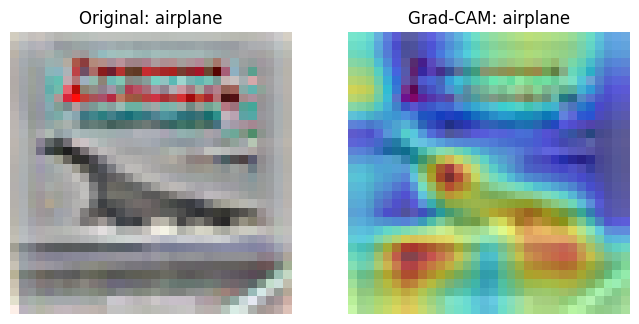

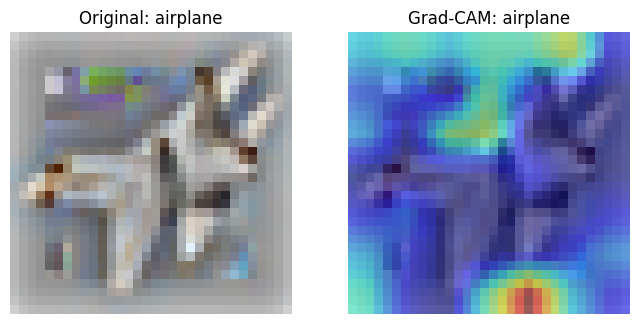

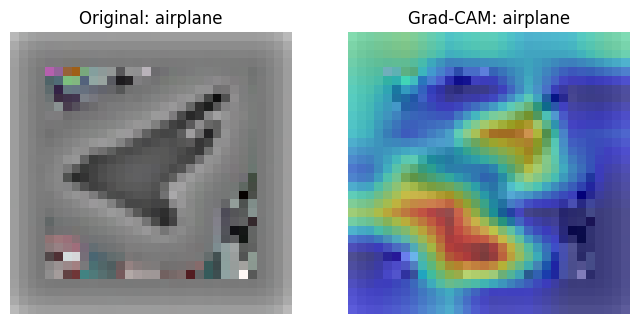

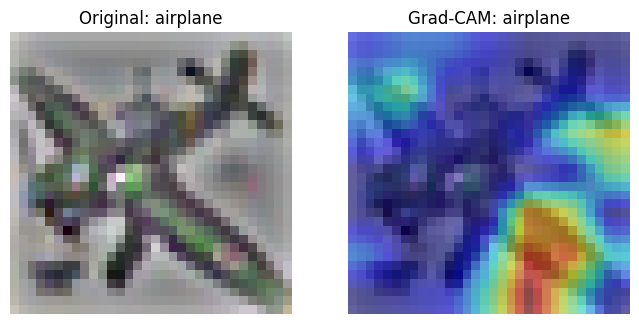

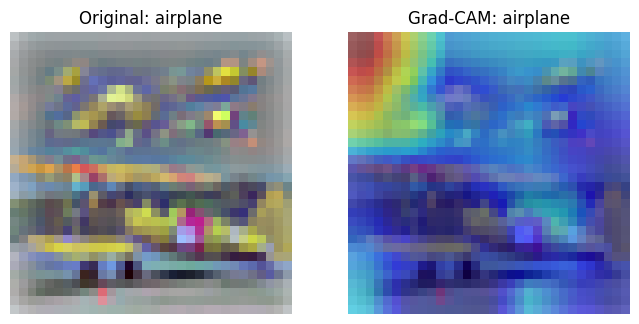

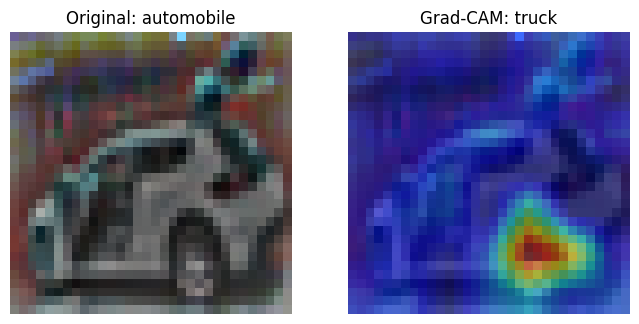

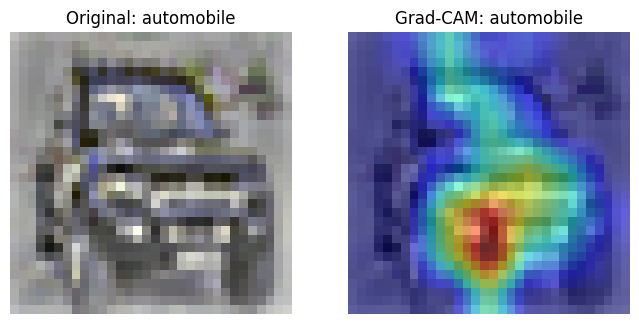

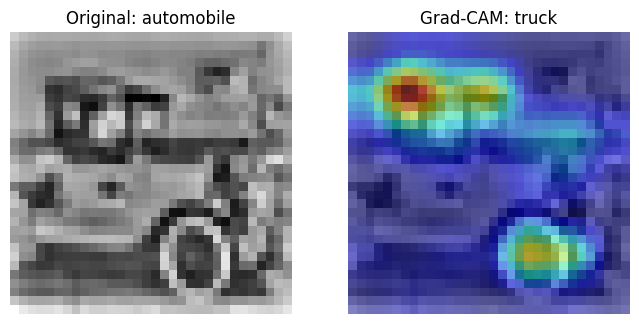

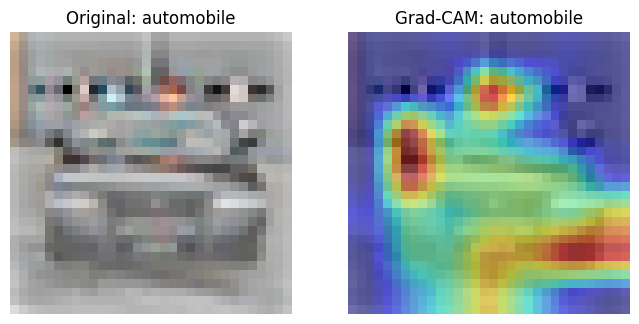

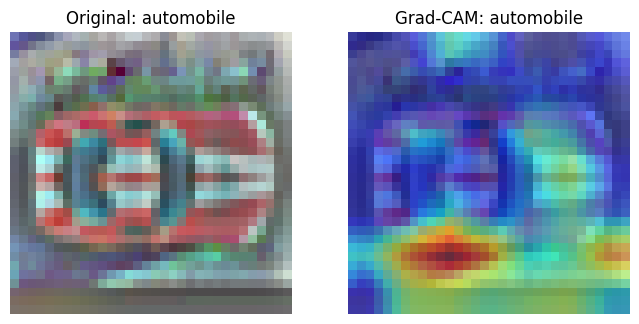

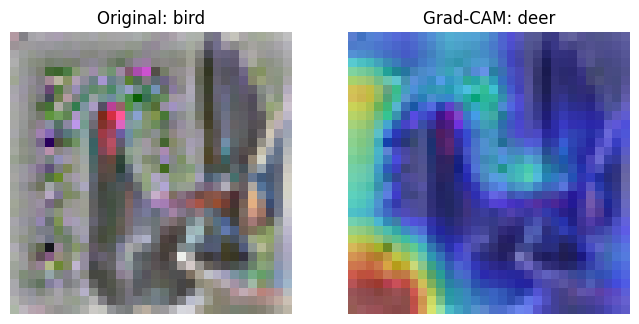

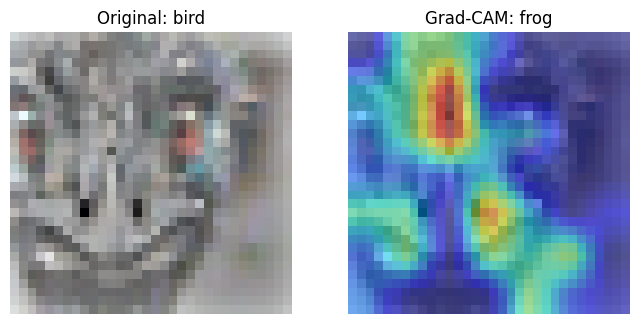

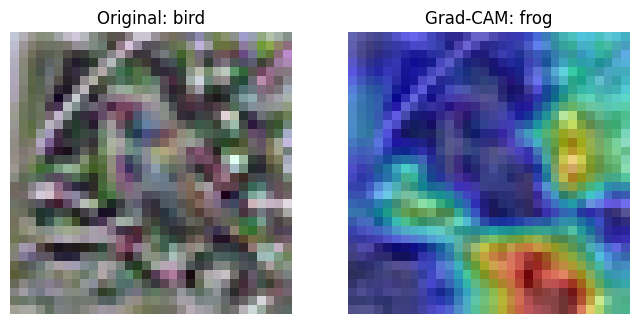

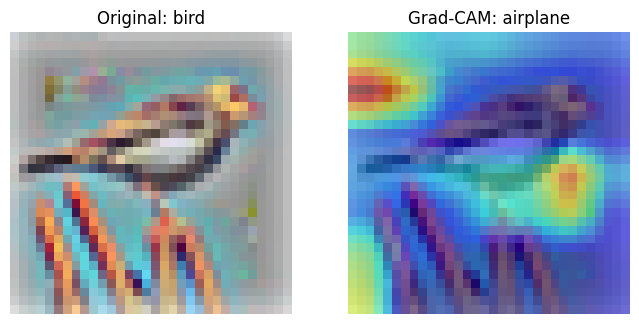

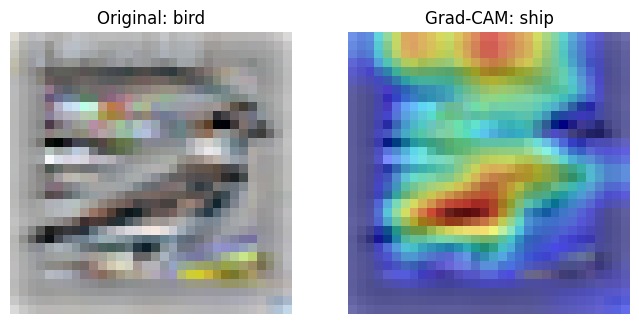

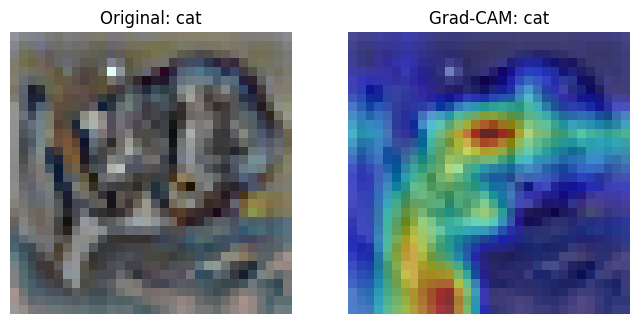

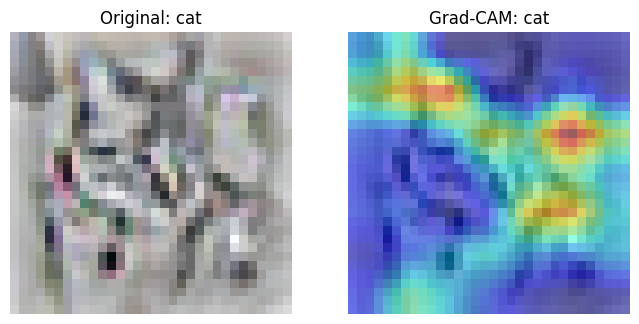

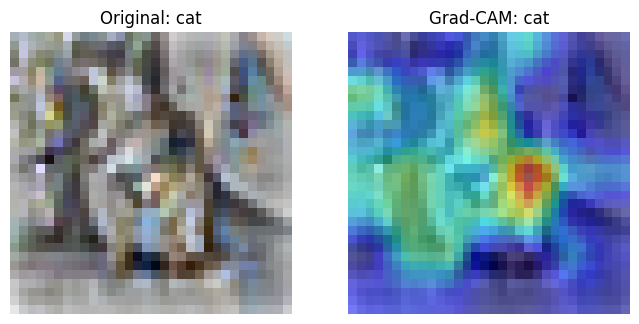

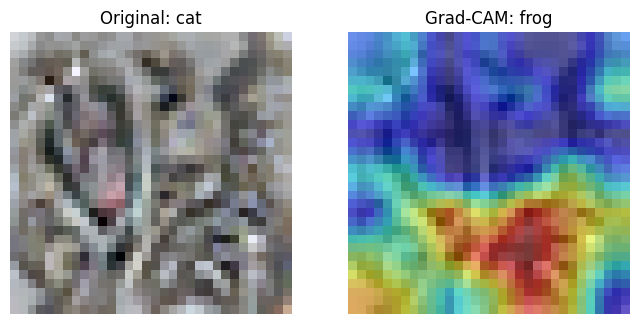

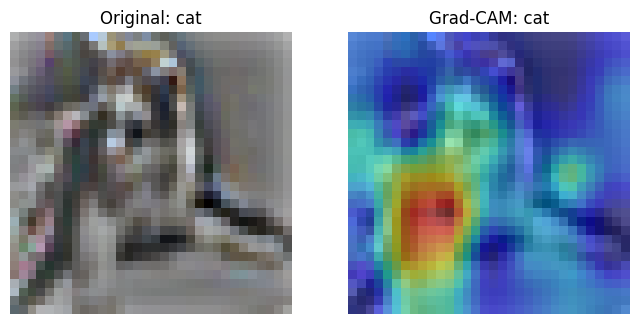

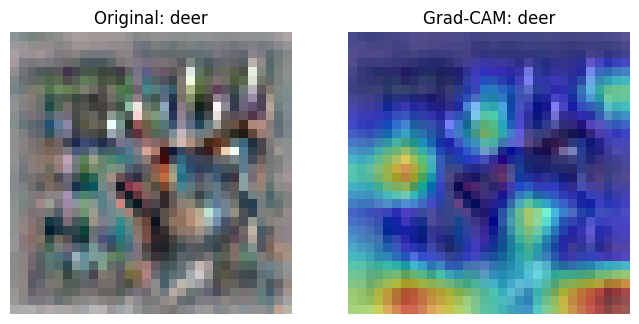

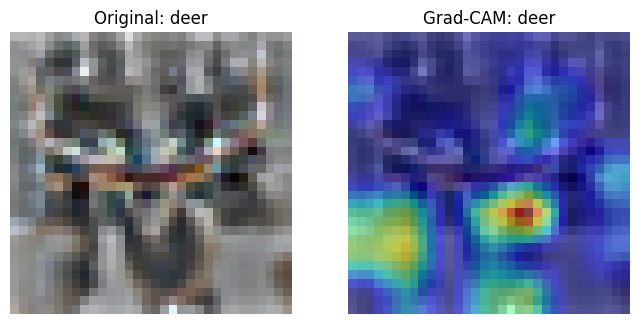

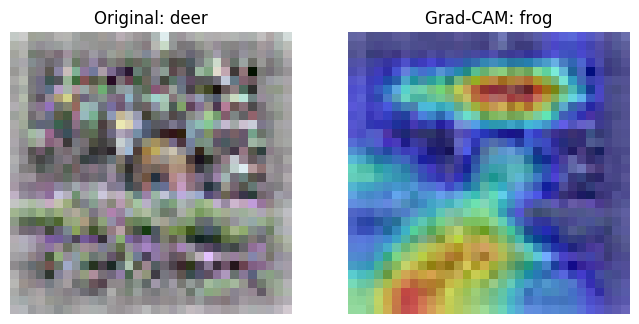

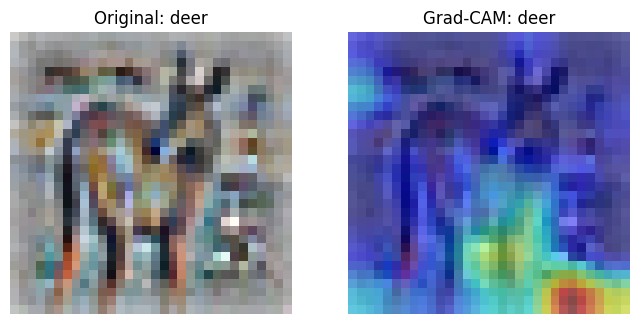

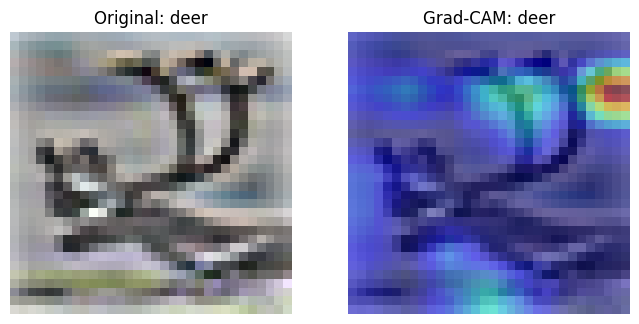

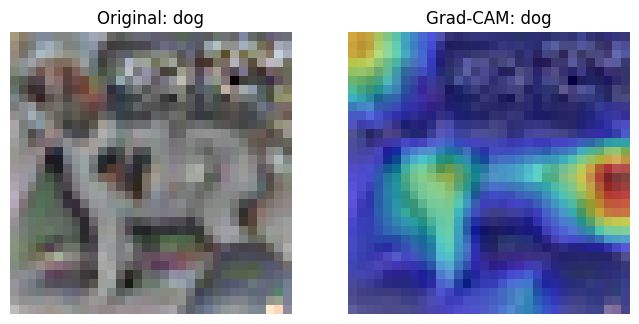

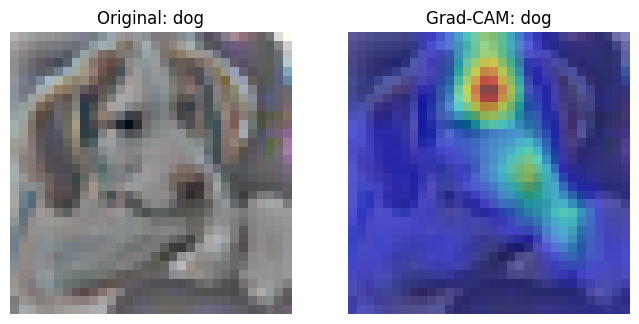

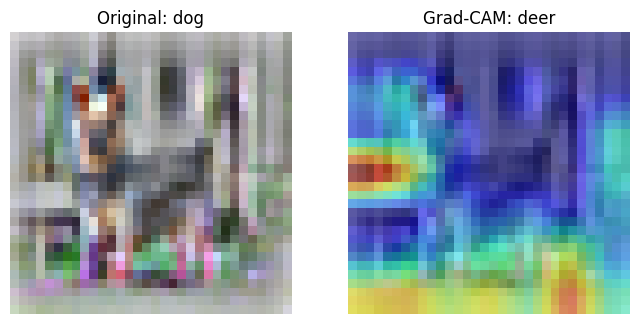

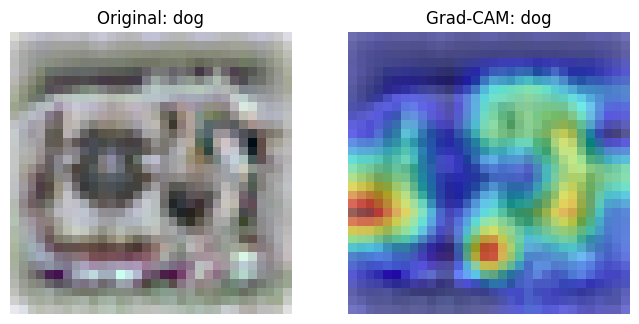

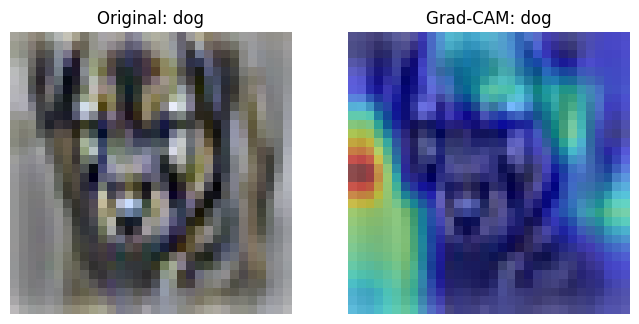

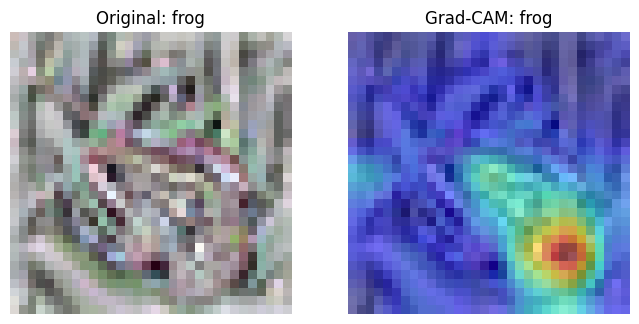

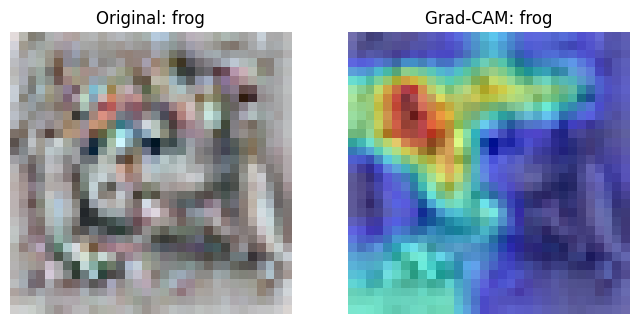

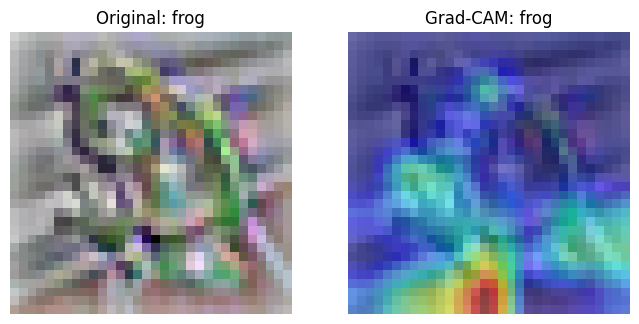

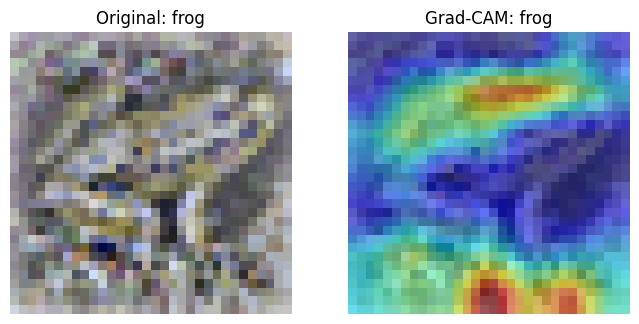

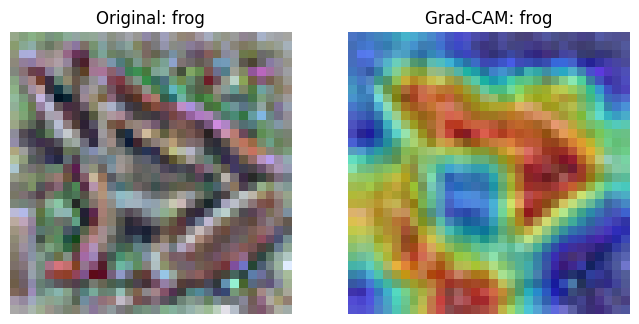

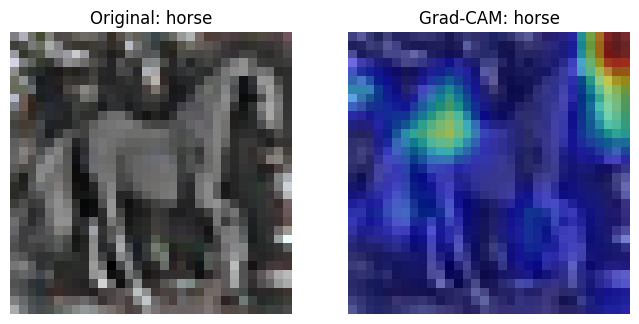

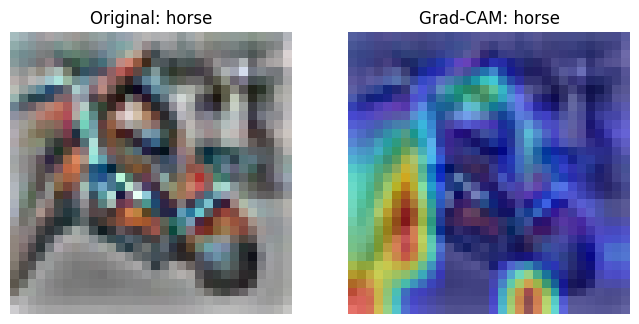

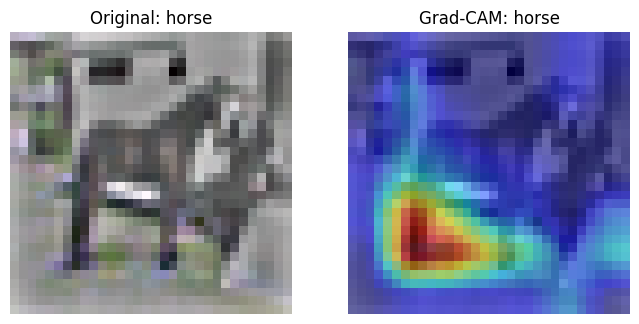

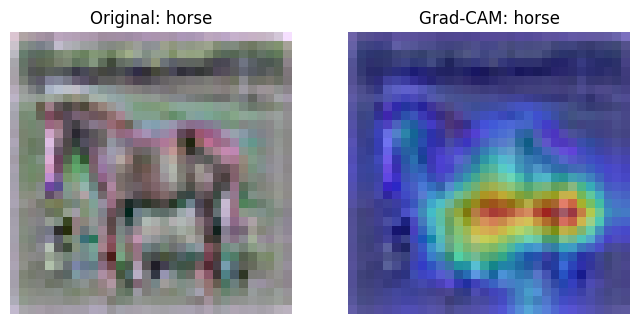

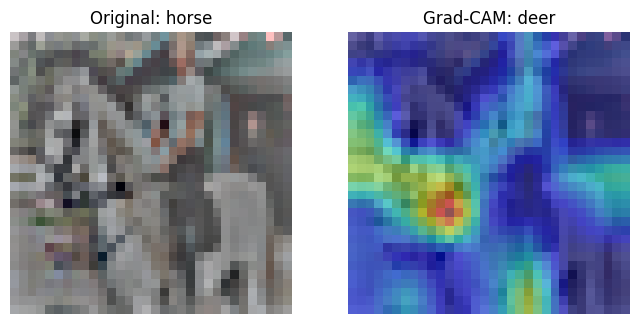

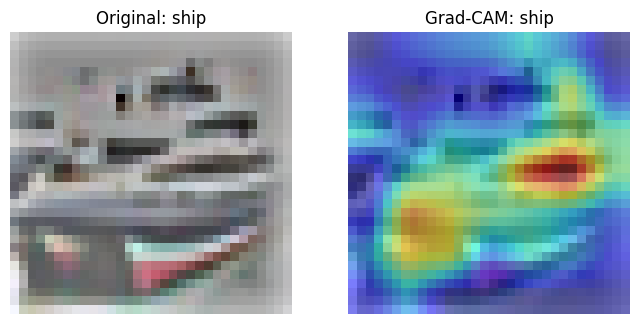

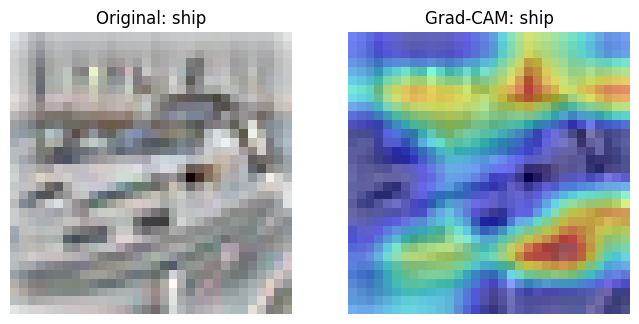

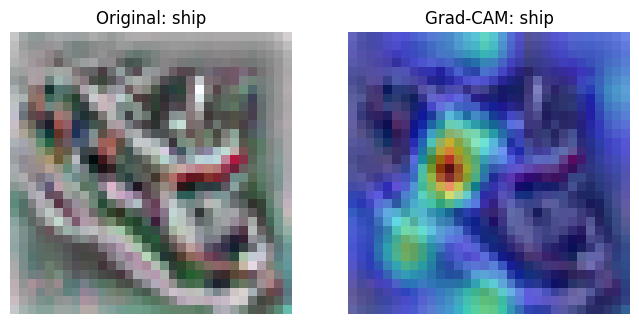

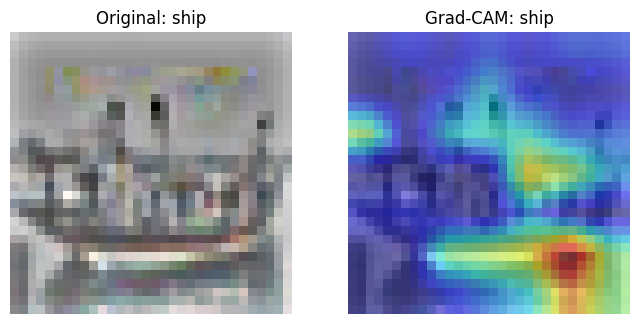

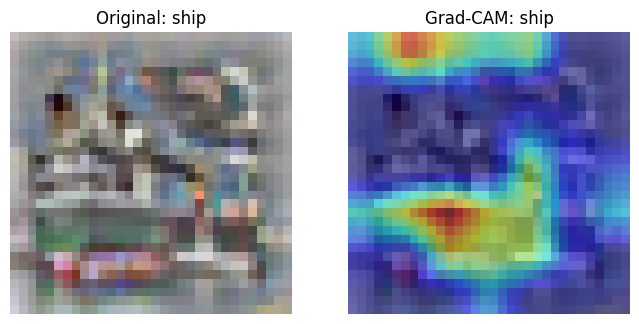

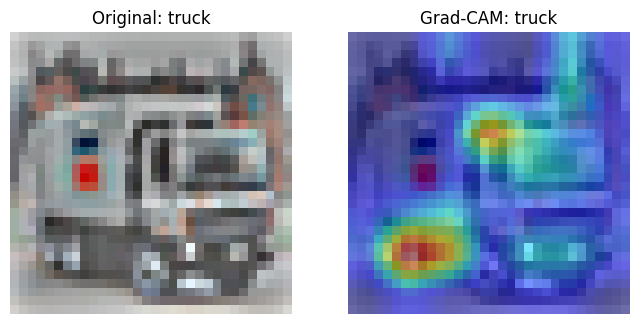

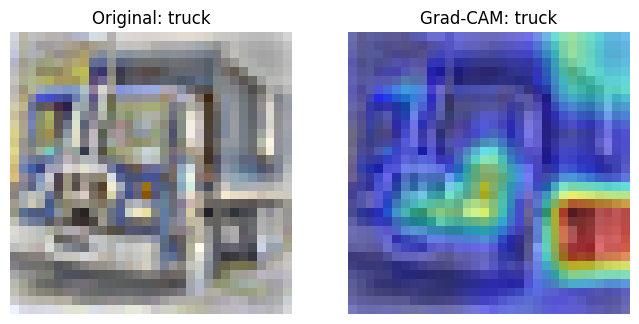

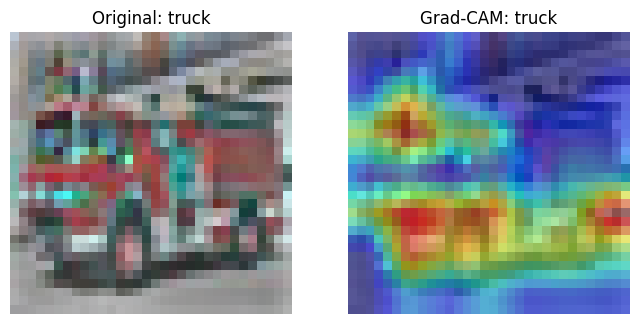

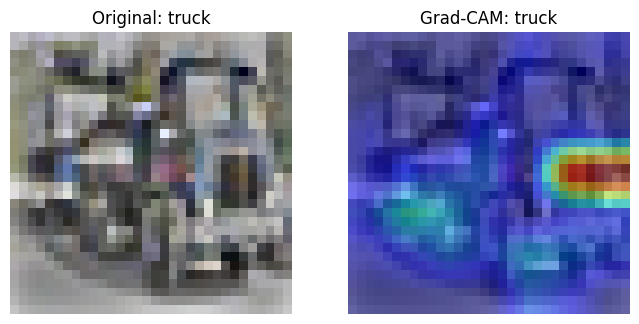

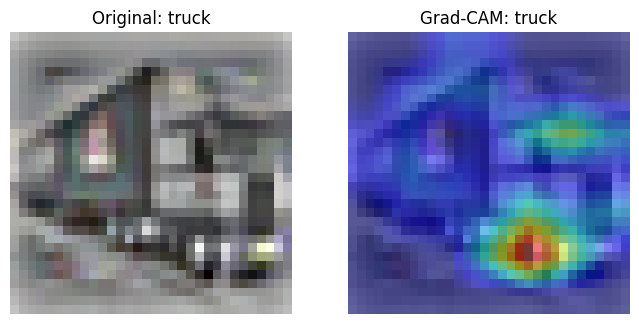

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

# For datasets and data loading
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# For numeric stability, etc.
torch.set_default_dtype(torch.float32)

def extract_random_patches(dataset,
                           num_patches=50000,
                           patch_size=3):
    """
    Extract random patches from images in a dataset.
    """
    all_patches = []
    extracted = 0
    while extracted < num_patches:
        i = random.randint(0, len(dataset) - 1)
        img, _ = dataset[i]  # (C,H,W)
        img_np = img.numpy()
        H, W = img_np.shape[1], img_np.shape[2]
        y = random.randint(0, H - patch_size)
        x = random.randint(0, W - patch_size)
        patch = img_np[:, y:y+patch_size, x:x+patch_size].reshape(-1)
        all_patches.append(patch)
        extracted += 1

    patches = np.array(all_patches, dtype=np.float32)
    return patches

def spherical_kmeans(X, num_clusters, max_iter=100, tol=1e-4, verbose=False):
    """
    Perform spherical k-means on data X.
    """
    N, D = X.shape
    indices = np.random.choice(N, num_clusters, replace=False)
    centers = X[indices]
    centers /= (np.linalg.norm(centers, axis=1, keepdims=True) + 1e-12)

    for it in range(max_iter):
        similarities = X @ centers.T
        labels = np.argmax(similarities, axis=1)
        new_centers = np.zeros_like(centers)
        count = np.zeros(num_clusters, dtype=np.int32)

        for i in range(N):
            new_centers[labels[i]] += X[i]
            count[labels[i]] += 1

        for c in range(num_clusters):
            if count[c] > 0:
                new_centers[c] /= count[c]

        new_centers /= (np.linalg.norm(new_centers, axis=1, keepdims=True) + 1e-12)
        shift = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if verbose:
            print(f"[SphericalKMeans Iter {it}] shift={shift:.6f}")
        if shift < tol:
            break

    return centers

def create_gaussian_kernel_2d(ksize=3, sigma=1.0):
    ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
    xx = ax.repeat(ksize, 1)
    yy = xx.t()
    kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    kernel = kernel / kernel.sum()
    return kernel.view(1, 1, ksize, ksize)

class GaussianPool2D(nn.Module):
    def __init__(self, kernel_size=3, sigma=1.0, stride=2):
        super().__init__()
        self.stride = stride
        gk = create_gaussian_kernel_2d(ksize=kernel_size, sigma=sigma)
        self.register_buffer('gk', gk)

    def forward(self, x):
        B, C, H, W = x.shape
        gk = self.gk.expand(C, 1, -1, -1)
        x = F.conv2d(x, gk, stride=self.stride, padding=1, groups=C)
        return x

class CKNLayer(nn.Module):
    def __init__(self,
                 in_channels,
                 patch_size=3,
                 num_filters=32,
                 alpha=10.0,
                 pool_ksize=3,
                 pool_sigma=1.0,
                 pool_stride=2):
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.num_filters = num_filters
        self.alpha = nn.Parameter(torch.tensor(alpha), requires_grad=True)

        D = in_channels * patch_size * patch_size
        self.Z = nn.Parameter(torch.randn(num_filters, D), requires_grad=True)

        M_init = torch.eye(num_filters)
        self.M = nn.Parameter(M_init, requires_grad=True)

        self.pool = GaussianPool2D(kernel_size=pool_ksize, sigma=pool_sigma, stride=pool_stride)

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch_size

        patches = F.unfold(x, kernel_size=p, padding=0, stride=1)
        H_sub = H - p + 1
        W_sub = W - p + 1

        patches = patches.permute(0, 2, 1)  # (B, L, D)
        patch_norms = torch.norm(patches, dim=2, keepdim=True) + 1e-12
        patches_normalized = patches / patch_norms

        Z_t = self.Z.t()
        dot_products = patches_normalized @ Z_t

        # kappa_1(t) = exp(alpha * (t - 1))
        features = torch.exp(self.alpha * (dot_products - 1.0))
        features = features @ self.M  # shape (B, L, num_filters)

        features = features.permute(0, 2, 1).contiguous()
        features = features.view(B, self.num_filters, H_sub, W_sub)

        features = self.pool(features)
        return features

def update_M_from_Z(ckn_layer):
    with torch.no_grad():
        Z = ckn_layer.Z
        alpha = ckn_layer.alpha.item()
        ZZt = Z @ Z.t()
        K = torch.exp(alpha * (ZZt - 1.0))
        e, v = torch.linalg.eigh(K)
        e_inv_sqrt = e.clamp(min=1e-12).rsqrt()
        M = (v * e_inv_sqrt.unsqueeze(0)) @ v.t()
        ckn_layer.M.copy_(M)

class LocalContrastNormalizationTransform:
    def __init__(self, kernel_size=9, sigma=2.0, eps=1e-8):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.eps = eps
        self.kernel_2d = self._create_gaussian_kernel_2d(kernel_size, sigma)

    def _create_gaussian_kernel_2d(self, ksize, sigma):
        ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
        xx = ax.repeat(ksize, 1)
        yy = xx.t()
        kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
        kernel /= kernel.sum()
        return kernel.view(1, 1, ksize, ksize)

    def __call__(self, img):
        if img.dim() != 3:
            raise ValueError("Input tensor must have shape (C, H, W).")

        C, H, W = img.shape
        img = img.unsqueeze(0)  # (1, C, H, W)
        kernel = self.kernel_2d.expand(C, 1, self.kernel_size, self.kernel_size)

        local_mean = F.conv2d(img, kernel, padding=self.kernel_size // 2, groups=C)
        local_mean_sq = F.conv2d(img * img, kernel, padding=self.kernel_size // 2, groups=C)

        local_var = local_mean_sq - local_mean * local_mean
        local_var = torch.clamp(local_var, min=0.0)
        local_std = torch.sqrt(local_var + self.eps)

        normalized = (img - local_mean) / local_std
        normalized = normalized.squeeze(0)
        return normalized

#
# CKN model (same as before)
#
class CKN(nn.Module):
    def __init__(self,
                 input_channels=3,
                 layer1_filters=32,
                 layer2_filters=64,
                 patch_size=3,
                 num_classes=10):
        super().__init__()

        self.layer1 = CKNLayer(in_channels=input_channels,
                               patch_size=patch_size,
                               num_filters=layer1_filters,
                               alpha=10.0,
                               pool_ksize=3,
                               pool_sigma=1.0,
                               pool_stride=2)

        self.layer2 = CKNLayer(in_channels=layer1_filters,
                               patch_size=patch_size,
                               num_filters=layer2_filters,
                               alpha=10.0,
                               pool_ksize=3,
                               pool_sigma=1.0,
                               pool_stride=2)

        # LazyLinear: will initialize in first forward pass
        self.classifier = nn.LazyLinear(num_classes)

        # For older "CAM" (linear weighting) we store feature_maps:
        self.feature_maps = None
        self.fc = self.classifier  # alias so we can write model.fc.weight.data

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        # Store feature maps for the simple "CAM" overlay
        self.feature_maps = x

        # Flatten then classify
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

###################################################
#             Grad-CAM Implementation            #
###################################################
def compute_gradcam(model, images, target_classes, device):
    """
    Compute Grad-CAM for a batch of images, given the final predicted (or chosen) class indices.

    Args:
        model:           The neural network (CKN) instance
        images:          A batch of images, shape (B, C, H, W)
        target_classes:  A tensor of class indices, shape (B,)
                         (which class you want the Grad-CAM for each image)
        device:          The torch device (cpu/cuda)

    Returns:
        cams: A tensor of shape (B, H_layer2, W_layer2) with Grad-CAM heatmaps.
    """
    # Make sure model is in eval mode
    model.eval()

    # Lists to store the forward activations and backward gradients for layer2
    conv_activations = []
    conv_gradients = []

    # Define forward hook: captures the output of layer2
    def forward_hook(module, inp, out):
        conv_activations.append(out)

    # Define backward hook: captures gradients w.r.t. the output of layer2
    def backward_hook(module, grad_in, grad_out):
        # grad_out is a tuple; grad_out[0] is the gradient of the output
        conv_gradients.append(grad_out[0])

    # Register the hooks
    # We specifically attach them to model.layer2 (the final CKNLayer),
    # but you can choose another layer for a different viewpoint.
    handle_f = model.layer2.register_forward_hook(forward_hook)
    handle_b = model.layer2.register_backward_hook(backward_hook)

    # 1) Forward pass
    outputs = model(images)
    # 2) We will compute gradients w.r.t. the chosen class scores
    #    Usually we pick the predicted class, or a target class the user wants.
    #    We'll gather the predicted class score for each image.
    selected_scores = outputs.gather(1, target_classes.view(-1, 1)).squeeze()

    # 3) Backward pass
    model.zero_grad()
    selected_scores.sum().backward(retain_graph=True)

    # Remove hooks
    handle_f.remove()
    handle_b.remove()

    # The forward hook stored the layer2 activation in conv_activations[0]
    # The backward hook stored the layer2 gradient in conv_gradients[0]
    activations = conv_activations[0]   # shape (B, C, H, W)
    gradients   = conv_gradients[0]     # shape (B, C, H, W)

    # We compute the channel-wise mean of the gradients: alpha_k
    # shape (B, C)
    alpha = gradients.view(gradients.size(0), gradients.size(1), -1).mean(dim=2)

    # Weighted sum of activations: sum_k( alpha_k * A_k ), then ReLU
    B, C, H, W = activations.shape
    cams = torch.zeros((B, H, W), device=device, dtype=activations.dtype)

    for i in range(B):
        # Multiply each channel by alpha[i, k], then sum
        weights = alpha[i].view(C, 1, 1)               # shape (C,1,1)
        cam_raw = (activations[i] * weights).sum(dim=0)  # shape (H, W)
        cam_relu = F.relu(cam_raw)
        # Normalize the map to [0,1]
        cam_min, cam_max = cam_relu.min(), cam_relu.max()
        cam_norm = (cam_relu - cam_min) / (cam_max - cam_min + 1e-8)
        cams[i] = cam_norm

    return cams  # shape (B, H, W)


def overlay_gradcam_on_image(model, images, labels, class_names, device):
    """
    Overlay the Grad-CAM heatmap (from layer2) on each of the input images.
    Uses the predicted class for each image as the target for Grad-CAM.
    """
    model.eval()
    # 1) Get predictions to know which class we want Grad-CAM for
    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    # 2) Compute the Grad-CAM for each predicted class
    cams = compute_gradcam(model, images, predicted, device)  # shape (B, H2, W2)

    # We'll need to upsample from (H2, W2) to the input resolution (e.g. 32x32)
    # But note that your final feature map might not be exactly 8x8 or something,
    # so we do a simple resize via PIL or F.interpolate
    B, _, _ = cams.shape

    # Move everything to CPU for plotting
    images_np = images.cpu().numpy()
    cams_np = cams.detach().cpu().numpy()

    # We'll figure out your input size from the images:
    _, _, H_in, W_in = images.shape

    for i in range(B):
        cam = cams_np[i]
        # Convert to [0,1] just to be safe
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        # Resize CAM to match input resolution
        cam_img = Image.fromarray(cam).resize((W_in, H_in), Image.BILINEAR)
        cam_img = np.array(cam_img)

        # Original image as [0,1]
        img = images_np[i]
        img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Original: {class_names[labels[i]]}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.imshow(cam_img, cmap='jet', alpha=0.5)
        plt.title(f'Grad-CAM: {class_names[predicted[i]]}')
        plt.axis('off')
        plt.show()


def plot_specific_images_gradcam(model, dataset, indices, class_names, device):
    """
    Similar to plot_specific_images, but uses the Grad-CAM overlay.
    """
    model.eval()
    images = []
    labels = []
    for idx in indices:
        image, label = dataset[idx]
        images.append(image)
        labels.append(label)

    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    overlay_gradcam_on_image(model, images, labels, class_names, device)

def update_M_from_Z(ckn_layer):
    """
    Recompute M = [kappa_1(Z^T Z)]^{-1/2} for the given layer.
    """
    with torch.no_grad():
        Z = ckn_layer.Z
        alpha = ckn_layer.alpha.item()
        ZZt = Z @ Z.t()
        K = torch.exp(alpha * (ZZt - 1.0))
        e, v = torch.linalg.eigh(K)
        e_inv_sqrt = e.clamp(min=1e-12).rsqrt()
        M = (v * e_inv_sqrt.unsqueeze(0)) @ v.t()
        ckn_layer.M.copy_(M)

###################################################
#                 Main Training                   #
###################################################
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = 128
    epochs = 20
    patch_size = 3
    layer1_filters = 32
    layer2_filters = 64
    num_clusters1 = layer1_filters
    num_clusters2 = layer2_filters

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])

    cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

    # We can define test_dataset = cifar_test for convenience:
    test_dataset = cifar_test

    # For CIFAR-10, class names can be gotten directly:
    class_names = cifar_train.classes  # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    print("Extracting patches for layer1...")
    X_patches_1 = extract_random_patches(cifar_train, num_patches=20000, patch_size=patch_size)
    norms = np.linalg.norm(X_patches_1, axis=1, keepdims=True) + 1e-12
    X_patches_1 /= norms
    print("Running spherical k-means for layer1...")
    centers1 = spherical_kmeans(X_patches_1, num_clusters=num_clusters1, max_iter=50, verbose=True)

    print("Building CKN model...")
    model = CKN(input_channels=3,
                layer1_filters=layer1_filters,
                layer2_filters=layer2_filters,
                patch_size=patch_size,
                num_classes=10).to(device)

    with torch.no_grad():
        model.layer1.Z.copy_(torch.from_numpy(centers1))
    update_M_from_Z(model.layer1)

    print("Extracting patches for layer2 (using layer1 as feature extractor)...")
    subset_size = 1000
    X_feats_list = []
    for i in range(subset_size):
        img, _ = cifar_train[i]
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            feat1 = model.layer1(img)
        feat1_np = feat1.cpu().numpy()[0]
        _, h1, w1 = feat1_np.shape
        for _ in range(5):
            y = random.randint(0, h1 - patch_size)
            x = random.randint(0, w1 - patch_size)
            patch = feat1_np[:, y:y+patch_size, x:x+patch_size].reshape(-1)
            X_feats_list.append(patch)

    X_patches_2 = np.array(X_feats_list, dtype=np.float32)
    norms = np.linalg.norm(X_patches_2, axis=1, keepdims=True) + 1e-12
    X_patches_2 /= norms

    print("Running spherical k-means for layer2...")
    if X_patches_2.shape[0] < num_clusters2:
        print("Warning: not enough patches for layer2.")
        centers2 = np.random.randn(num_clusters2, layer1_filters*patch_size*patch_size).astype(np.float32)
        centers2 /= (np.linalg.norm(centers2, axis=1, keepdims=True) + 1e-12)
    else:
        centers2 = spherical_kmeans(X_patches_2, num_clusters=num_clusters2, max_iter=50, verbose=True)

    with torch.no_grad():
        model.layer2.Z.copy_(torch.from_numpy(centers2))
    update_M_from_Z(model.layer2)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("Start training...")
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += imgs.size(0)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Loss: {total_loss/total:.4f} | "
              f"Acc: {100.0*correct/total:.2f}%")

    print("Training done.")

    print("Evaluating on CIFAR-10 test set...")
    model.eval()
    correct = 0
    total = 0

    # For per-class accuracy, store counts
    num_classes = 10
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)

            # Overall accuracy stats
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Per-class accuracy stats
            for i in range(labels.size(0)):
                label_i = labels[i].item()
                pred_i = predicted[i].item()
                if pred_i == label_i:
                    class_correct[label_i] += 1
                class_total[label_i] += 1

    test_accuracy = 100.0 * correct / total
    print(f"Test Accuracy (overall): {test_accuracy:.2f}%")

    # Print accuracy for each class
    for i in range(num_classes):
        if class_total[i] == 0:
            acc_i = 0  # Avoid division by zero if there's an empty class
        else:
            acc_i = 100.0 * class_correct[i] / class_total[i]
        print(f"Accuracy for class {class_names[i]:12s}: {acc_i:.2f}%")

     # Example: pick 1 image for each class to visualize with Grad-CAM
    label_indices = [[] for _ in range(10)]
    for i, (_, label) in enumerate(test_dataset):
        if len(label_indices[label]) < 5:
            label_indices[label].append(i)
    chosen_indices = sum(label_indices, [])  # single list

    # Plot Grad-CAM on the chosen images:
    plot_specific_images_gradcam(model, test_dataset, chosen_indices, class_names, device)


if __name__ == "__main__":
    main()


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import numpy as np
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001

# SVHN normalization constants (simple choice of mean/std=0.5)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# SVHN Dataset
train_dataset = torchvision.datasets.SVHN(
    root='./data',
    split='train',
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.SVHN(
    root='./data',
    split='test',
    transform=transform,
    download=True
)

# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

def extract_patches(x, kernel_size, stride):
    B, C, H, W = x.shape
    patches = x.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
    patches = patches.contiguous().view(B, C, -1, kernel_size, kernel_size)
    patches = patches.permute(0, 2, 3, 4, 1).contiguous()
    patches = patches.view(-1, kernel_size * kernel_size * C)
    return patches

def normalize_patches(patches):
    mean = patches.mean(dim=1, keepdim=True)
    patches -= mean
    norm = torch.norm(patches, p=2, dim=1, keepdim=True)
    norm = torch.clamp(norm, min=1e-6)
    return patches / norm

class CKNNLayer(nn.Module):
    def __init__(self, in_channels, kernel_size, stride, num_filters, pool_size, pool_stride, gamma=1.0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.num_filters = num_filters
        self.pool = nn.AvgPool2d(pool_size, stride=pool_stride)
        self.gamma = gamma
        self.in_channels = in_channels
        self.register_buffer('filters', None)

    def set_filters(self, filters):
        self.filters = filters

    def forward(self, x):
        B, C, H, W = x.shape

        # Extract and normalize patches
        patches = extract_patches(x, self.kernel_size, self.stride)
        patches = normalize_patches(patches)

        # Compute Gaussian kernel activations
        filters = self.filters.view(self.num_filters, -1)
        distances = torch.cdist(patches, filters, p=2)
        activations = torch.exp(-self.gamma * distances**2)

        # Reshape and pool
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1
        activations = activations.view(B, H_out, W_out, self.num_filters).permute(0, 3, 1, 2)
        return self.pool(activations)

class CKN(nn.Module):
    def __init__(self, layer_specs, num_classes):
        super().__init__()
        # Updated to 3 channels for SVHN
        in_channels = 3

        self.layers = nn.ModuleList()
        for spec in layer_specs:
            self.layers.append(
                CKNNLayer(
                    in_channels=in_channels,
                    kernel_size=spec['kernel_size'],
                    stride=spec['stride'],
                    num_filters=spec['num_filters'],
                    pool_size=spec['pool_size'],
                    pool_stride=spec['pool_stride'],
                    gamma=spec['gamma']
                )
            )
            in_channels = spec['num_filters']

        # After two layers with 2×2 pooling each time on 32×32 input:
        # final feature map is (128 filters) × 6 × 6 → 128 * 6 * 6 = 4608
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(128 * 6 * 6, 256),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(256, num_classes)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.classifier(x)

def train_ckn_layers(model, train_loader, device):
    model.eval()
    prev_outputs = []
    for i, layer in enumerate(model.layers):
        print(f"Training layer {i+1}/{len(model.layers)}...")
        start_time = time.time()

        # Collect inputs for the current layer
        if i == 0:
            inputs = []
            for images, _ in train_loader:
                inputs.append(images.to(device))
            inputs = torch.cat(inputs, dim=0)
        else:
            inputs = prev_outputs

        # Extract and normalize patches (with subsampling)
        patches_list = []
        # Break inputs into chunks to avoid OOM
        for batch in inputs.chunk(100):
            patches = extract_patches(batch, layer.kernel_size, layer.stride)
            patches = normalize_patches(patches)
            patches_list.append(patches.cpu().numpy())

        all_patches = np.concatenate(patches_list, axis=0)

        # Subsample patches for faster clustering
        n_samples = min(100000, all_patches.shape[0])
        all_patches = all_patches[np.random.choice(all_patches.shape[0], n_samples, replace=False)]

        # K-means clustering
        kmeans = KMeans(n_clusters=layer.num_filters, random_state=0, n_init=10)
        kmeans.fit(all_patches)
        filters = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=device)
        layer.set_filters(filters)

        # Update prev_outputs for next layer
        with torch.no_grad():
            prev_outputs = []
            # Evaluate the current layer’s output
            for batch in inputs.chunk(100):
                prev_outputs.append(layer(batch))
            prev_outputs = torch.cat(prev_outputs, dim=0)

        print(f"Layer {i+1} trained in {time.time()-start_time:.2f}s")

    model.train()

# Model configuration for SVHN
layer_specs = [
    {
        'kernel_size': 5,
        'stride': 1,
        'num_filters': 64,
        'pool_size': 2,
        'pool_stride': 2,
        'gamma': 0.5
    },
    {
        'kernel_size': 3,
        'stride': 1,
        'num_filters': 128,
        'pool_size': 2,
        'pool_stride': 2,
        'gamma': 0.5
    }
]

model = CKN(layer_specs, num_classes=10).to(device)

# Train filters layer-wise
print("Training CKN filters...")
train_ckn_layers(model, train_loader, device)

# Train classifier
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Training loop
total_step = len(train_loader)
print("Starting classifier training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Step [{i+1}/{total_step}], '
                  f'Loss: {loss.item():.4f}')

    # Update learning rate
    scheduler.step(running_loss / total_step)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


100%|██████████| 182M/182M [00:40<00:00, 4.54MB/s]


100%|██████████| 64.3M/64.3M [00:23<00:00, 2.71MB/s]


Training CKN filters...
Training layer 1/2...
Layer 1 trained in 73.08s
Training layer 2/2...
Layer 2 trained in 351.19s
Starting classifier training...
Epoch [1/10], Step [100/573], Loss: 2.2191
Epoch [1/10], Step [200/573], Loss: 2.2209
Epoch [1/10], Step [300/573], Loss: 2.3000
Epoch [1/10], Step [400/573], Loss: 2.2508
Epoch [1/10], Step [500/573], Loss: 2.2696
Epoch [2/10], Step [100/573], Loss: 2.3055
Epoch [2/10], Step [200/573], Loss: 2.2302
Epoch [2/10], Step [300/573], Loss: 2.2453
Epoch [2/10], Step [400/573], Loss: 2.1856
Epoch [2/10], Step [500/573], Loss: 2.2125
Epoch [3/10], Step [100/573], Loss: 2.1615
Epoch [3/10], Step [200/573], Loss: 2.1864
Epoch [3/10], Step [300/573], Loss: 2.1698
Epoch [3/10], Step [400/573], Loss: 2.2507
Epoch [3/10], Step [500/573], Loss: 2.1965
Epoch [4/10], Step [100/573], Loss: 2.1635
Epoch [4/10], Step [200/573], Loss: 2.2261
Epoch [4/10], Step [300/573], Loss: 2.1429
Epoch [4/10], Step [400/573], Loss: 2.2027
Epoch [4/10], Step [500/573], 

100%|██████████| 182M/182M [00:31<00:00, 5.80MB/s]


100%|██████████| 64.3M/64.3M [00:27<00:00, 2.32MB/s]


Using downloaded and verified file: ./data/test_32x32.mat
Extracting patches for layer1...
Running spherical k-means for layer1...
[SphericalKMeans Iter 0] shift=1.475998
[SphericalKMeans Iter 1] shift=0.678566
[SphericalKMeans Iter 2] shift=0.421907
[SphericalKMeans Iter 3] shift=0.293729
[SphericalKMeans Iter 4] shift=0.297950
[SphericalKMeans Iter 5] shift=0.460898
[SphericalKMeans Iter 6] shift=0.484562
[SphericalKMeans Iter 7] shift=0.238807
[SphericalKMeans Iter 8] shift=0.156221
[SphericalKMeans Iter 9] shift=0.151726
[SphericalKMeans Iter 10] shift=0.113731
[SphericalKMeans Iter 11] shift=0.105664
[SphericalKMeans Iter 12] shift=0.094653
[SphericalKMeans Iter 13] shift=0.089395
[SphericalKMeans Iter 14] shift=0.100454
[SphericalKMeans Iter 15] shift=0.106471
[SphericalKMeans Iter 16] shift=0.099239
[SphericalKMeans Iter 17] shift=0.080295
[SphericalKMeans Iter 18] shift=0.079684
[SphericalKMeans Iter 19] shift=0.072797
[SphericalKMeans Iter 20] shift=0.068926
[SphericalKMeans I

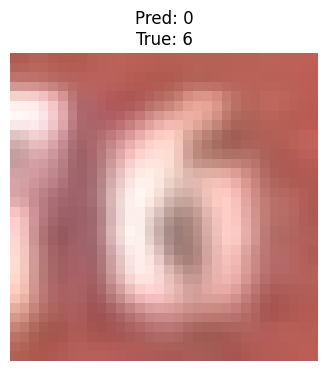

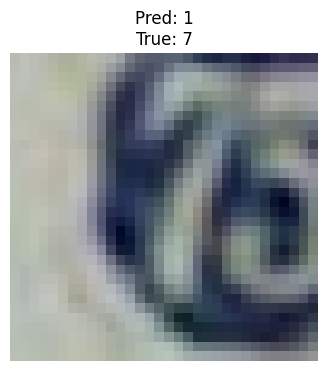

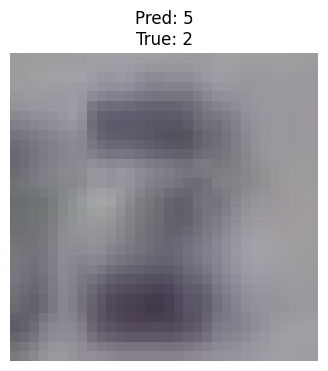

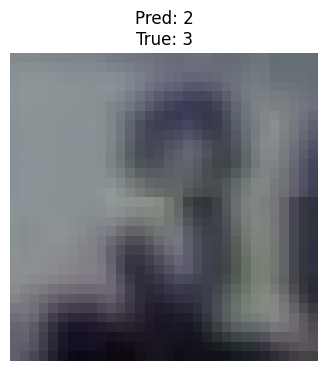

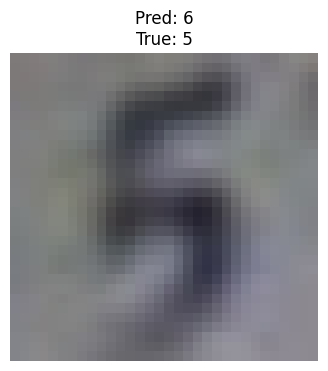

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import random

# For datasets and data loading
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# For numeric stability, etc.
torch.set_default_dtype(torch.float32)

########################################################
# LocalContrastNormalizationTransform (same as before) #
########################################################
class LocalContrastNormalizationTransform:
    """
    Applies local contrast normalization (LCN) to a tensor image of shape (C, H, W).
    The image is convolved with a Gaussian kernel to compute local mean and variance.
    Then each pixel is normalized: (x - local_mean) / sqrt(local_var + eps).
    """
    def __init__(self, kernel_size=9, sigma=2.0, eps=1e-8):
        """
        Args:
            kernel_size: int, size of the square Gaussian kernel (e.g., 9).
            sigma: float, std dev of the Gaussian kernel.
            eps: small constant to avoid division by zero.
        """
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.eps = eps

        # Precompute 2D Gaussian kernel of shape (1,1,ksize,ksize)
        self.kernel_2d = self._create_gaussian_kernel_2d(kernel_size, sigma)

    def _create_gaussian_kernel_2d(self, ksize, sigma):
        """Builds a normalized 2D Gaussian kernel as a PyTorch tensor."""
        ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
        xx = ax.repeat(ksize, 1)
        yy = xx.t()
        kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
        kernel /= kernel.sum()
        return kernel.view(1, 1, ksize, ksize)  # shape (1,1,ksize,ksize)

    def __call__(self, img):
        """
        img: torch.Tensor of shape (C, H, W) in [0,1] or any range.
        Returns: normalized tensor of shape (C, H, W).
        """
        if img.dim() != 3:
            raise ValueError("Input tensor must have shape (C, H, W).")

        C, H, W = img.shape
        # Make batch dimension => (1, C, H, W)
        img = img.unsqueeze(0)

        # Expand kernel for group convolution: (C, 1, ksize, ksize)
        kernel = self.kernel_2d.expand(C, 1, self.kernel_size, self.kernel_size)

        # Compute local mean
        local_mean = F.conv2d(img, kernel, padding=self.kernel_size // 2, groups=C)
        # Compute local mean of squares
        local_mean_sq = F.conv2d(img * img, kernel, padding=self.kernel_size // 2, groups=C)

        # var = E[x^2] - E[x]^2
        local_var = local_mean_sq - local_mean * local_mean
        # clamp to avoid negative numeric issues
        local_var = torch.clamp(local_var, min=0.0)
        local_std = torch.sqrt(local_var + self.eps)

        # LCN: (x - local_mean) / local_std
        normalized = (img - local_mean) / local_std

        # Remove the batch dimension => shape (C, H, W)
        normalized = normalized.squeeze(0)

        return normalized

######################################
# Helper functions (same as before)  #
######################################

def extract_random_patches(dataset,
                           num_patches=50000,
                           patch_size=3):
    """
    Extract random patches from images in a dataset.

    Args:
        dataset: A PyTorch dataset (each sample is (C, H, W)).
        num_patches: How many patches to extract in total.
        patch_size: Spatial size of the square patch (e.g. 3).

    Returns:
        patches: A numpy array of shape (num_patches, C*patch_size*patch_size).
    """
    # We'll accumulate patches here
    all_patches = []

    # Number of patches extracted so far
    extracted = 0

    # Randomly sample from dataset
    while extracted < num_patches:
        i = random.randint(0, len(dataset) - 1)
        img, _ = dataset[i]  # (C, H, W), float tensor in [0,1]

        # Convert to numpy if needed
        img_np = img.numpy()

        # Random location for the patch
        C = img_np.shape[0]
        H = img_np.shape[1]
        W = img_np.shape[2]
        y = random.randint(0, H - patch_size)
        x = random.randint(0, W - patch_size)

        patch = img_np[:, y:y+patch_size, x:x+patch_size].reshape(-1)
        all_patches.append(patch)
        extracted += 1

    patches = np.array(all_patches, dtype=np.float32)
    return patches

def spherical_kmeans(X, num_clusters, max_iter=100, tol=1e-4, verbose=False):
    """
    Perform spherical k-means clustering on data X.

    Args:
        X: numpy array of shape (N, D) with rows as data points.
        num_clusters: number of clusters (dictionary size).
        max_iter: max iterations.
        tol: convergence tolerance.
        verbose: whether to print debug info.

    Returns:
        centers: numpy array of shape (num_clusters, D), each row is a center on the unit sphere.
    """
    N, D = X.shape

    # Random init of cluster centers
    indices = np.random.choice(N, num_clusters, replace=False)
    centers = X[indices]

    # Normalize centers to unit norm
    centers = centers / (np.linalg.norm(centers, axis=1, keepdims=True) + 1e-12)

    for it in range(max_iter):
        # Compute cosine similarities
        similarities = X @ centers.T  # (N, num_clusters)

        # Assign each sample to the closest center
        labels = np.argmax(similarities, axis=1)

        # Recompute centers
        new_centers = np.zeros_like(centers)
        count = np.zeros(num_clusters, dtype=np.int32)

        for i in range(N):
            new_centers[labels[i]] += X[i]
            count[labels[i]] += 1

        for c in range(num_clusters):
            if count[c] > 0:
                new_centers[c] /= count[c]

        # Re-normalize
        norms = np.linalg.norm(new_centers, axis=1, keepdims=True) + 1e-12
        new_centers = new_centers / norms

        # Check for convergence
        shift = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if verbose:
            print(f"[SphericalKMeans Iter {it}] shift={shift:.6f}")
        if shift < tol:
            break

    return centers

def create_gaussian_kernel_2d(ksize=3, sigma=1.0):
    """
    Creates a 2D Gaussian kernel of size ksize x ksize with std=sigma.
    Returns a PyTorch tensor of shape (1, 1, ksize, ksize).
    """
    ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
    xx = ax.repeat(ksize, 1)
    yy = xx.t()
    kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    kernel = kernel / kernel.sum()
    return kernel.view(1, 1, ksize, ksize)

class GaussianPool2D(nn.Module):
    """
    Gaussian Pooling: convolve with a fixed Gaussian kernel, then subsample.
    """
    def __init__(self, kernel_size=3, sigma=1.0, stride=2):
        super().__init__()
        self.stride = stride
        gk = create_gaussian_kernel_2d(ksize=kernel_size, sigma=sigma)
        self.register_buffer('gk', gk)

    def forward(self, x):
        # x shape: (B, C, H, W)
        B, C, H, W = x.shape
        # group convolution trick
        gk = self.gk.expand(C, 1, -1, -1)
        x = F.conv2d(x, gk, stride=self.stride, padding=1, groups=C)
        return x

class CKNLayer(nn.Module):
    def __init__(self,
                 in_channels,
                 patch_size=3,
                 num_filters=32,
                 alpha=10.0,
                 pool_ksize=3,
                 pool_sigma=1.0,
                 pool_stride=2):
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.num_filters = num_filters
        self.alpha = nn.Parameter(torch.tensor(alpha), requires_grad=True)

        D = in_channels * patch_size * patch_size
        self.Z = nn.Parameter(torch.randn(num_filters, D), requires_grad=True)

        M_init = torch.eye(num_filters)
        self.M = nn.Parameter(M_init, requires_grad=True)

        self.pool = GaussianPool2D(kernel_size=pool_ksize, sigma=pool_sigma, stride=pool_stride)

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch_size

        # 1) Extract patches
        patches = F.unfold(x, kernel_size=p, padding=0, stride=1)  # (B, C*p*p, H_sub*W_sub)
        H_sub = H - p + 1
        W_sub = W - p + 1

        # 2) Normalize each patch
        patches = patches.permute(0, 2, 1)  # (B, L, D)
        patch_norms = torch.norm(patches, dim=2, keepdim=True) + 1e-12
        patches_normalized = patches / patch_norms

        # 3) Dot with Z^T
        Z_t = self.Z.t()  # (D, num_filters)
        dot_products = patches_normalized @ Z_t  # (B, L, num_filters)

        # 4) Apply kernel kappa_1(t) = exp(alpha * (t - 1))
        t = dot_products
        features = torch.exp(self.alpha * (t - 1.0))  # (B, L, num_filters)

        # 5) Multiply by M
        features = features @ self.M

        # 6) Reshape
        features = features.permute(0, 2, 1).contiguous()
        features = features.view(B, self.num_filters, H_sub, W_sub)

        # 7) Gaussian pooling
        features = self.pool(features)
        return features

def update_M_from_Z(ckn_layer):
    """
    Recompute M = [kappa_1(Z^T Z)]^{-1/2} for the given layer,
    where kappa_1(t) = exp(alpha*(t-1)).
    """
    with torch.no_grad():
        Z = ckn_layer.Z  # (p, D)
        alpha = ckn_layer.alpha.item()
        ZZt = Z @ Z.t()
        K = torch.exp(alpha * (ZZt - 1.0))

        e, v = torch.linalg.eigh(K)
        e_inv_sqrt = e.clamp(min=1e-12).rsqrt()
        M = (v * e_inv_sqrt.unsqueeze(0)) @ v.t()
        ckn_layer.M.copy_(M)

class CKN(nn.Module):
    def __init__(self,
                 input_channels=3,
                 layer1_filters=32,
                 layer2_filters=64,
                 patch_size=3,
                 num_classes=10):
        super().__init__()

        self.layer1 = CKNLayer(in_channels=input_channels,
                               patch_size=patch_size,
                               num_filters=layer1_filters,
                               alpha=10.0,
                               pool_ksize=3,
                               pool_sigma=1.0,
                               pool_stride=2)

        self.layer2 = CKNLayer(in_channels=layer1_filters,
                               patch_size=patch_size,
                               num_filters=layer2_filters,
                               alpha=10.0,
                               pool_ksize=3,
                               pool_sigma=1.0,
                               pool_stride=2)

        self.classifier = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

#################################
# Main, now using SVHN instead! #
#################################
def main():
    import matplotlib.pyplot as plt

    # --- Hyperparams ---
    batch_size = 64
    epochs = 10
    patch_size = 3
    layer1_filters = 32
    layer2_filters = 64
    num_clusters1 = layer1_filters
    num_clusters2 = layer2_filters

    ##########################################
    # 1. Define transforms for training/test #
    ##########################################
    # LCN transforms for model training/evaluation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])

    # A "raw" transform for displaying original images (no LCN, no data augmentation)
    raw_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    #######################
    # 2. Load SVHN dataset
    #######################
    svhn_train = datasets.SVHN(
        root='./data',
        split='train',
        download=True,
        transform=transform_train
    )
    svhn_test = datasets.SVHN(
        root='./data',
        split='test',
        download=True,
        transform=transform_test
    )

    # "Raw" test dataset for displaying original images
    raw_svhn_test = datasets.SVHN(
        root='./data',
        split='test',
        download=True,
        transform=raw_transform
    )

    train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=False, num_workers=2)

    ######################################################
    # 3. Extract random patches (layer1) & run k-means    #
    ######################################################
    print("Extracting patches for layer1...")
    X_patches_1 = extract_random_patches(svhn_train, num_patches=20000, patch_size=patch_size)
    norms = np.linalg.norm(X_patches_1, axis=1, keepdims=True) + 1e-12
    X_patches_1 /= norms

    print("Running spherical k-means for layer1...")
    centers1 = spherical_kmeans(X_patches_1, num_clusters=num_clusters1, max_iter=50, verbose=True)

    ###################################################
    # 4. Build the CKN model and initialize layer1 Z  #
    ###################################################
    print("Building CKN model...")
    model = CKN(input_channels=3,
                layer1_filters=layer1_filters,
                layer2_filters=layer2_filters,
                patch_size=patch_size,
                num_classes=10)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        model.layer1.Z.copy_(torch.from_numpy(centers1))
    update_M_from_Z(model.layer1)

    ##################################################
    # 5. Extract patches (layer2) & run k-means      #
    ##################################################
    print("Extracting patches for layer2 (using layer1 output)...")
    subset_size = 1000
    X_feats_list = []
    for i in range(subset_size):
        img, _ = svhn_train[i]   # shape (C, H, W)
        img = img.unsqueeze(0).to(device)  # (1,3,H,W)
        with torch.no_grad():
            feat1 = model.layer1(img)      # (1, layer1_filters, H1, W1)
        feat1_np = feat1.cpu().numpy()[0]  # (layer1_filters, H1, W1)

        _, h1, w1 = feat1_np.shape
        for _ in range(5):
            if h1 < patch_size or w1 < patch_size:
                continue
            y = random.randint(0, h1 - patch_size)
            x = random.randint(0, w1 - patch_size)
            patch = feat1_np[:, y:y+patch_size, x:x+patch_size].reshape(-1)
            X_feats_list.append(patch)

    X_patches_2 = np.array(X_feats_list, dtype=np.float32)
    norms = np.linalg.norm(X_patches_2, axis=1, keepdims=True) + 1e-12
    X_patches_2 /= norms

    print("Running spherical k-means for layer2...")
    if X_patches_2.shape[0] < num_clusters2:
        print("Warning: not enough patches for second layer. Using random init for layer2.")
        centers2 = np.random.randn(num_clusters2, layer1_filters*patch_size*patch_size).astype(np.float32)
        centers2 /= (np.linalg.norm(centers2, axis=1, keepdims=True) + 1e-12)
    else:
        centers2 = spherical_kmeans(X_patches_2, num_clusters=num_clusters2, max_iter=50, verbose=True)

    with torch.no_grad():
        model.layer2.Z.copy_(torch.from_numpy(centers2))
    update_M_from_Z(model.layer2)

    ###################################
    # 6. Training loop (standard)     #
    ###################################
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("Start training...")
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += imgs.size(0)

        epoch_loss = total_loss / total
        epoch_acc = 100.0 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

    print("Training done.")

    ##########################
    # 7. Overall test score  #
    ##########################
    print("Evaluating on SVHN test set...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    test_accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    ##################################################
    # 8. Print per-class accuracy (digits 0 through 9)
    ##################################################
    class_correct = [0]*10
    class_total = [0]*10

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)

            for i in range(labels.size(0)):
                lbl = labels[i].item()
                pred = predicted[i].item()
                if lbl == pred:
                    class_correct[lbl] += 1
                class_total[lbl] += 1

    print("\n--- Per-class accuracy ---")
    class_names = [str(i) for i in range(10)]  # '0'..'9'
    for i in range(10):
        if class_total[i] == 0:
            acc_i = 0.0
        else:
            acc_i = 100.0 * class_correct[i] / class_total[i]
        print(f"Digit {class_names[i]} : {acc_i:.2f}%  "
              f"(Correct: {class_correct[i]}/{class_total[i]})")

    #########################################################################
    # 9. Show some misclassified examples, using a no-shuffle DataLoader and
    #    a "raw" (non-LCN) dataset for display.
    #########################################################################
    #  - We'll re-run a pass over SVHN test set with batch_size=1, shuffle=False
    #  - We'll store the misclassified indices, predictions, etc.
    #  - We'll fetch the *raw* image from raw_svhn_test for display
    #    so that we see the original (non-LCN) image.
    #########################################################################

    # Make a no-shuffle test loader with the LCN test dataset
    test_loader_no_shuffle = DataLoader(svhn_test, batch_size=1, shuffle=False)

    misclassified_indices = []
    misclassified_preds = []
    misclassified_labels = []

    idx = 0
    with torch.no_grad():
        for imgs, labels in test_loader_no_shuffle:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)

            if predicted.item() != labels.item():
                misclassified_indices.append(idx)
                misclassified_preds.append(predicted.item())
                misclassified_labels.append(labels.item())
            idx += 1

    print(f"\nTotal misclassified samples: {len(misclassified_indices)} out of {idx}.")
    num_to_show = 5
    if len(misclassified_indices) > 0:
        chosen = np.random.choice(len(misclassified_indices),
                                  size=min(num_to_show, len(misclassified_indices)),
                                  replace=False)

        for i_mis in chosen:
            idx_m = misclassified_indices[i_mis]
            pred_cls = class_names[misclassified_preds[i_mis]]
            true_cls = class_names[misclassified_labels[i_mis]]

            # Fetch the *raw* (non-LCN) image for display
            raw_img, _ = raw_svhn_test[idx_m]  # shape (C,H,W)
            # Convert [C,H,W] -> [H,W,C]
            raw_img_np = raw_img.permute(1, 2, 0).numpy()

            plt.figure(figsize=(4,4))
            plt.imshow(raw_img_np, interpolation='none')
            plt.title(f"Pred: {pred_cls}\nTrue: {true_cls}")
            plt.axis("off")
            plt.show()


if __name__ == "__main__":
    main()


Cloning Fruits 360 dataset from GitHub...
Found 131 fruit classes.
Extracting patches for layer1...
Running spherical k-means for layer1...
[SphericalKMeans Iter 0] shift=1.859298
[SphericalKMeans Iter 1] shift=0.939664
[SphericalKMeans Iter 2] shift=0.491945
[SphericalKMeans Iter 3] shift=0.318160
[SphericalKMeans Iter 4] shift=0.230744
[SphericalKMeans Iter 5] shift=0.204541
[SphericalKMeans Iter 6] shift=0.163925
[SphericalKMeans Iter 7] shift=0.143915
[SphericalKMeans Iter 8] shift=0.145657
[SphericalKMeans Iter 9] shift=0.130071
[SphericalKMeans Iter 10] shift=0.106435
[SphericalKMeans Iter 11] shift=0.101315
[SphericalKMeans Iter 12] shift=0.102066
[SphericalKMeans Iter 13] shift=0.086615
[SphericalKMeans Iter 14] shift=0.079301
[SphericalKMeans Iter 15] shift=0.080115
[SphericalKMeans Iter 16] shift=0.087587
[SphericalKMeans Iter 17] shift=0.068469
[SphericalKMeans Iter 18] shift=0.061388
[SphericalKMeans Iter 19] shift=0.046470
[SphericalKMeans Iter 20] shift=0.061137
[Spherica

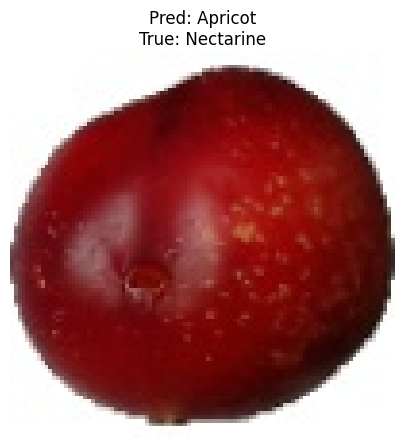

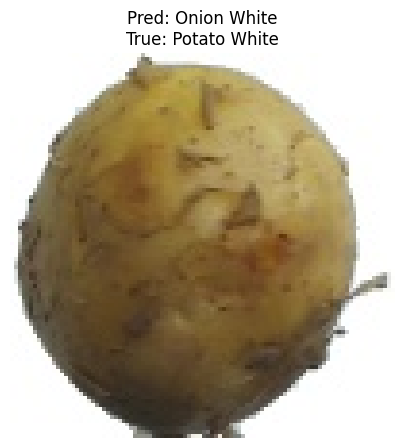

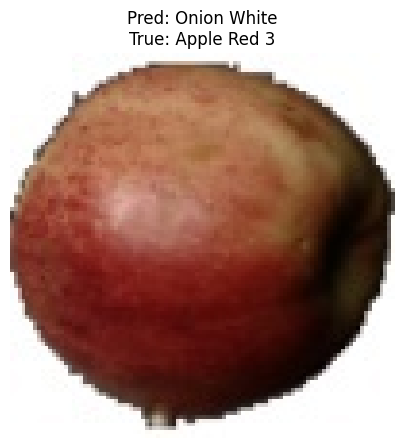

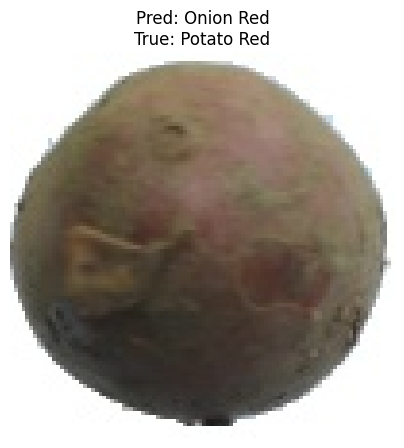

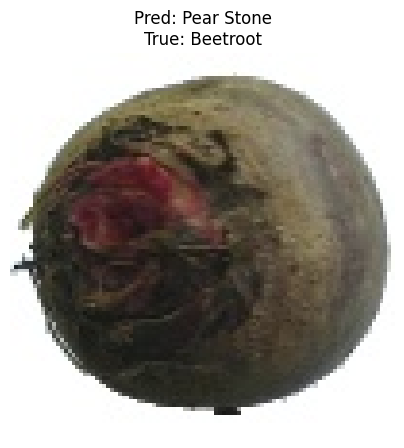

In [ ]:
import os
import subprocess
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

########################################################
# 1) Fetch the Fruits 360 dataset (if not present)
########################################################
if not os.path.exists("Fruit-Images-Dataset"):
    print("Cloning Fruits 360 dataset from GitHub...")
    subprocess.run(["git", "clone", "https://github.com/Horea94/Fruit-Images-Dataset.git"])
else:
    print("Fruits 360 dataset directory already exists.")


########################################################
# 2) Local Contrast Normalization transform
########################################################
import torch
import torch.nn.functional as F

class LocalContrastNormalizationTransform:
    """
    Applies local contrast normalization (LCN) to a tensor image of shape (C, H, W).
    Each channel is normalized independently by convolving with a Gaussian kernel.
    """
    def __init__(self, kernel_size=9, sigma=2.0, eps=1e-8):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.eps = eps
        self.kernel_2d = self._create_gaussian_kernel_2d(kernel_size, sigma)

    def _create_gaussian_kernel_2d(self, ksize, sigma):
        """
        Create a normalized 2D Gaussian kernel (1,1,ksize,ksize).
        """
        ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
        xx = ax.repeat(ksize, 1)
        yy = xx.t()
        kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
        kernel /= kernel.sum()
        return kernel.view(1, 1, ksize, ksize)  # shape = [1,1,ksize,ksize]

    def __call__(self, img):
        """
        img shape: (C,H,W) in [0,1].
        Returns: (C,H,W) normalized.
        """
        if img.dim() != 3:
            raise ValueError("Expected input of shape (C, H, W). Got shape: {}".format(img.shape))

        # Add a batch dimension => (1, C, H, W)
        img = img.unsqueeze(0)  # shape = [1, C, H, W]
        B, C, H, W = img.shape

        # Expand kernel to shape [C, 1, kernel_size, kernel_size]
        kernel = self.kernel_2d.expand(C, 1, self.kernel_size, self.kernel_size)

        # 1) Local mean
        local_mean = F.conv2d(img, kernel, padding=self.kernel_size//2, groups=C)

        # 2) Local mean of squares
        local_mean_sq = F.conv2d(img * img, kernel, padding=self.kernel_size//2, groups=C)

        # 3) Variance = E[x^2] - E[x]^2
        local_var = local_mean_sq - local_mean**2
        local_var = torch.clamp(local_var, min=0.0)
        local_std = torch.sqrt(local_var + self.eps)

        # 4) LCN
        normalized = (img - local_mean) / local_std

        # Squeeze back to (C,H,W)
        normalized = normalized.squeeze(0)
        return normalized



########################################################
# 3) Patch extraction utility
########################################################
def extract_random_patches(dataset,
                           num_patches=50000,
                           patch_size=3):
    """
    Extract random patches from images in a dataset.

    Args:
        dataset: A PyTorch dataset (each sample is (C, H, W)).
        num_patches: How many patches to extract in total.
        patch_size: Spatial size of the square patch (e.g. 3).

    Returns:
        patches: A numpy array of shape (num_patches, C*patch_size*patch_size).
    """
    all_patches = []
    extracted = 0

    while extracted < num_patches:
        i = random.randint(0, len(dataset) - 1)
        img, _ = dataset[i]  # (C, H, W)
        # Convert to numpy
        img_np = img.numpy()
        C, H, W = img_np.shape
        # Random location for the patch
        y = random.randint(0, H - patch_size)
        x = random.randint(0, W - patch_size)

        patch = img_np[:, y:y+patch_size, x:x+patch_size].reshape(-1)
        all_patches.append(patch)
        extracted += 1

    patches = np.array(all_patches, dtype=np.float32)
    return patches


########################################################
# 4) Spherical K-Means
########################################################
def spherical_kmeans(X, num_clusters, max_iter=100, tol=1e-4, verbose=False):
    """
    Perform spherical k-means clustering on data X.

    Args:
        X: numpy array of shape (N, D) with rows as data points.
        num_clusters: number of clusters (dictionary size).
        max_iter: max iterations.
        tol: convergence tolerance.
        verbose: whether to print debug info.

    Returns:
        centers: numpy array of shape (num_clusters, D).
    """
    N, D = X.shape
    indices = np.random.choice(N, num_clusters, replace=False)
    centers = X[indices]
    centers = centers / (np.linalg.norm(centers, axis=1, keepdims=True) + 1e-12)

    for it in range(max_iter):
        similarities = X @ centers.T  # (N, num_clusters)
        labels = np.argmax(similarities, axis=1)

        new_centers = np.zeros_like(centers)
        count = np.zeros(num_clusters, dtype=np.int32)

        for i in range(N):
            new_centers[labels[i]] += X[i]
            count[labels[i]] += 1

        for c in range(num_clusters):
            if count[c] > 0:
                new_centers[c] /= count[c]

        norms = np.linalg.norm(new_centers, axis=1, keepdims=True) + 1e-12
        new_centers = new_centers / norms

        shift = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if verbose:
            print(f"[SphericalKMeans Iter {it}] shift={shift:.6f}")
        if shift < tol:
            break

    return centers


########################################################
# 5) Gaussian pool layer
########################################################
def create_gaussian_kernel_2d(ksize=3, sigma=1.0):
    """
    Creates a 2D Gaussian kernel of size ksize x ksize with std=sigma.
    Returns a PyTorch tensor of shape (1, 1, ksize, ksize).
    """
    ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
    xx = ax.repeat(ksize, 1)
    yy = xx.t()
    kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    kernel = kernel / kernel.sum()
    return kernel.view(1, 1, ksize, ksize)


class GaussianPool2D(nn.Module):
    """
    Gaussian Pooling: convolve with a fixed Gaussian kernel, then subsample.
    """
    def __init__(self, kernel_size=3, sigma=1.0, stride=2):
        super().__init__()
        self.stride = stride
        gk = create_gaussian_kernel_2d(ksize=kernel_size, sigma=sigma)
        self.register_buffer('gk', gk)

    def forward(self, x):
        B, C, H, W = x.shape
        gk = self.gk.expand(C, 1, -1, -1)
        x = F.conv2d(x, gk, stride=self.stride, padding=1, groups=C)
        return x


########################################################
# 6) CKN Layer
########################################################
class CKNLayer(nn.Module):
    def __init__(self,
                 in_channels,
                 patch_size=3,
                 num_filters=32,
                 alpha=10.0,
                 pool_ksize=3,
                 pool_sigma=1.0,
                 pool_stride=2):
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.num_filters = num_filters
        self.alpha = nn.Parameter(torch.tensor(alpha), requires_grad=True)

        D = in_channels * patch_size * patch_size
        self.Z = nn.Parameter(torch.randn(num_filters, D), requires_grad=True)
        M_init = torch.eye(num_filters)
        self.M = nn.Parameter(M_init, requires_grad=True)

        self.pool = GaussianPool2D(kernel_size=pool_ksize,
                                   sigma=pool_sigma,
                                   stride=pool_stride)

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch_size

        # 1) Extract patches
        patches = F.unfold(x, kernel_size=p, padding=0, stride=1)  # (B, C*p*p, H_sub*W_sub)
        H_sub = H - p + 1
        W_sub = W - p + 1

        # 2) Normalize patches
        patches = patches.permute(0, 2, 1)  # (B, L, D)
        patch_norms = torch.norm(patches, dim=2, keepdim=True) + 1e-12
        patches_normalized = patches / patch_norms

        # 3) Dot with Z^T
        Z_t = self.Z.t()  # (D, num_filters)
        dot_products = patches_normalized @ Z_t  # (B, L, num_filters)

        # 4) Kernel kappa_1(t) = exp(alpha * (t - 1))
        features = torch.exp(self.alpha * (dot_products - 1.0))

        # 5) Multiply by M
        features = features @ self.M

        # 6) Reshape
        features = features.permute(0, 2, 1).contiguous()
        features = features.view(B, self.num_filters, H_sub, W_sub)

        # 7) Gaussian pooling
        features = self.pool(features)
        return features


def update_M_from_Z(ckn_layer):
    """
    Recompute M = [kappa_1(Z^T Z)]^{-1/2} for the given layer,
    where kappa_1(t) = exp(alpha*(t-1)).
    """
    with torch.no_grad():
        Z = ckn_layer.Z  # (p, D)
        alpha = ckn_layer.alpha.item()
        ZZt = Z @ Z.t()
        K = torch.exp(alpha * (ZZt - 1.0))

        e, v = torch.linalg.eigh(K)
        e_inv_sqrt = e.clamp(min=1e-12).rsqrt()
        M = (v * e_inv_sqrt.unsqueeze(0)) @ v.t()

        ckn_layer.M.copy_(M)


########################################################
# 7) Full CKN model (2-layer)
########################################################
class CKN(nn.Module):
    def __init__(self,
                 input_channels=3,
                 layer1_filters=32,
                 layer2_filters=64,
                 patch_size=3,
                 num_classes=10):
        super().__init__()

        self.layer1 = CKNLayer(in_channels=input_channels,
                               patch_size=patch_size,
                               num_filters=layer1_filters,
                               alpha=10.0,
                               pool_ksize=3,
                               pool_sigma=1.0,
                               pool_stride=2)

        self.layer2 = CKNLayer(in_channels=layer1_filters,
                               patch_size=patch_size,
                               num_filters=layer2_filters,
                               alpha=10.0,
                               pool_ksize=3,
                               pool_sigma=1.0,
                               pool_stride=2)

        # LazyLinear so we can figure out the output dim after a dummy forward.
        self.classifier = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x


########################################################
# 8) Main: train & test on Fruits 360
########################################################
def main():
    import matplotlib.pyplot as plt

    # --- Basic hyperparameters ---
    batch_size = 64
    epochs = 5   # Fewer epochs for demo
    patch_size = 3
    layer1_filters = 32
    layer2_filters = 64
    num_patches_layer1 = 20000
    num_patches_layer2 = 10000
    max_kmeans_iter = 25

    # 1. Define transforms for training/test (with LCN), resizing to 32x32 for the model
    transform_train = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])
    transform_test = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])

    # (A) "Raw" transform for *display only* (no resizing, no LCN) => original quality
    raw_transform = transforms.Compose([
        # Do NOT resize here if you want original image size
        transforms.ToTensor()
    ])

    # 2. Fruits 360 data directories
    train_dir = "Fruit-Images-Dataset/Training"
    test_dir  = "Fruit-Images-Dataset/Test"

    # 3. Create training/test dataset & loaders
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=transform_test)

    # "Raw" test dataset for displaying original images
    raw_test_dataset = datasets.ImageFolder(root=test_dir, transform=raw_transform)

    num_classes = len(train_dataset.classes)
    print(f"Found {num_classes} fruit classes.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

    # 4. Extract random patches for layer1 + spherical k-means
    print("Extracting patches for layer1...")
    X_patches_1 = extract_random_patches(train_dataset, num_patches=num_patches_layer1, patch_size=patch_size)
    norms_1 = np.linalg.norm(X_patches_1, axis=1, keepdims=True) + 1e-12
    X_patches_1 /= norms_1
    print("Running spherical k-means for layer1...")
    centers1 = spherical_kmeans(X_patches_1, num_clusters=layer1_filters, max_iter=max_kmeans_iter, verbose=True)

    # 5. Build the CKN model
    print("Building CKN model...")
    model = CKN(input_channels=3,
                layer1_filters=layer1_filters,
                layer2_filters=layer2_filters,
                patch_size=patch_size,
                num_classes=num_classes)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Load layer1 centroids
    with torch.no_grad():
        model.layer1.Z.copy_(torch.from_numpy(centers1))
    update_M_from_Z(model.layer1)

    # 6. Extract patches for layer2 (via layer1 features) + spherical k-means
    print("Extracting patches for layer2 (via layer1 features)...")
    X_feats_list = []
    subset_size = 500
    for i in range(min(subset_size, len(train_dataset))):
        img, _ = train_dataset[i]
        img = img.unsqueeze(0).to(device)  # shape (1,3,H,W)
        with torch.no_grad():
            feat1 = model.layer1(img)
        feat1_np = feat1.cpu().numpy()[0]  # (layer1_filters, H1, W1)

        C1, h1, w1 = feat1_np.shape
        for _ in range(5):
            if h1 < patch_size or w1 < patch_size:
                continue
            y = random.randint(0, h1 - patch_size)
            x = random.randint(0, w1 - patch_size)
            patch = feat1_np[:, y:y+patch_size, x:x+patch_size].reshape(-1)
            X_feats_list.append(patch)

    X_patches_2 = np.array(X_feats_list, dtype=np.float32)
    if len(X_patches_2) == 0:
        print("No patches extracted for layer2. Using random centers instead.")
        X_patches_2 = np.random.randn(layer2_filters, layer1_filters * patch_size * patch_size).astype(np.float32)

    norms_2 = np.linalg.norm(X_patches_2, axis=1, keepdims=True) + 1e-12
    X_patches_2 /= norms_2

    print("Running spherical k-means for layer2...")
    if X_patches_2.shape[0] < layer2_filters:
        print("Not enough patches for layer2. Using random init.")
        centers2 = np.random.randn(layer2_filters, layer1_filters * patch_size * patch_size).astype(np.float32)
        centers2 /= (np.linalg.norm(centers2, axis=1, keepdims=True) + 1e-12)
    else:
        centers2 = spherical_kmeans(X_patches_2, num_clusters=layer2_filters, max_iter=max_kmeans_iter, verbose=True)

    with torch.no_grad():
        model.layer2.Z.copy_(torch.from_numpy(centers2))
    update_M_from_Z(model.layer2)

    # 7. Training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    print("Start training...")
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total_samples = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total_samples += imgs.size(0)

        epoch_loss = total_loss / total_samples
        epoch_acc = 100.0 * correct / total_samples
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

    # 8. Overall test accuracy
    print("Evaluating on Fruits 360 test set...")
    model.eval()
    correct = 0
    total_samples = 0
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(imgs)
            _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    test_acc = 100.0 * correct / total_samples
    print(f"Test Accuracy: {test_acc:.2f}%")

    # 9. Print per-class accuracy
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)

            for i in range(labels.size(0)):
                lbl = labels[i].item()
                pred = predicted[i].item()
                if lbl == pred:
                    class_correct[lbl] += 1
                class_total[lbl] += 1

    print("\n--- Per-class accuracy ---")
    for i, cls_name in enumerate(train_dataset.classes):
        if class_total[i] == 0:
            acc_i = 0.0
        else:
            acc_i = 100.0 * class_correct[i] / class_total[i]
        print(f"{cls_name:30s} : {acc_i:6.2f}% ({class_correct[i]}/{class_total[i]})")

    # 10. Display misclassified examples (one figure per image, using raw dataset)
    test_loader_no_shuffle = DataLoader(test_dataset, batch_size=1, shuffle=False)

    misclassified_indices = []
    misclassified_preds = []
    misclassified_labels = []

    idx = 0
    with torch.no_grad():
        for img, label in test_loader_no_shuffle:
            img = img.to(device)
            output = model(img)
            _, pred = output.max(1)

            if pred.item() != label.item():
                misclassified_indices.append(idx)
                misclassified_preds.append(pred.item())
                misclassified_labels.append(label.item())
            idx += 1

    print(f"\nTotal misclassified samples: {len(misclassified_indices)} out of {idx}.")

    # Instead of subplots, make separate figures for each example
    num_to_show = 5
    if len(misclassified_indices) > 0:
        chosen = np.random.choice(len(misclassified_indices),
                                  size=min(num_to_show, len(misclassified_indices)),
                                  replace=False)

        for i_mis in chosen:
            actual_idx = misclassified_indices[i_mis]  # <-- IMPORTANT FIX
            pred_cls = test_dataset.classes[misclassified_preds[i_mis]]
            true_cls = test_dataset.classes[misclassified_labels[i_mis]]

            # fetch the RAW image for display (original size, no LCN)
            raw_img_tensor, _ = raw_test_dataset[actual_idx]  # Use actual_idx here
            # shape (C,H,W)
            img_np = raw_img_tensor.permute(1, 2, 0).numpy()  # => [H,W,C]

            # Create a new figure for each image
            plt.figure(figsize=(5,5))
            plt.imshow(img_np, interpolation='none')  # 'none' => exact pixels, no smoothing
            plt.title(f"Pred: {pred_cls}\nTrue: {true_cls}")
            plt.axis("off")
            plt.show()






if __name__ == "__main__":
    main()


In [ ]:
import os
import subprocess
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

########################################################
# 1) Fetch the Fruits 360 dataset (if not present)
########################################################
if not os.path.exists("Fruit-Images-Dataset"):
    print("Cloning Fruits 360 dataset from GitHub...")
    subprocess.run(["git", "clone", "https://github.com/Horea94/Fruit-Images-Dataset.git"])
else:
    print("Fruits 360 dataset directory already exists.")


########################################################
# 2) Local Contrast Normalization (LCN) Transform
########################################################
class LocalContrastNormalizationTransform:
    def __init__(self, kernel_size=9, sigma=2.0, eps=1e-8):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.eps = eps
        self.kernel_2d = self._create_gaussian_kernel_2d(kernel_size, sigma)

    def _create_gaussian_kernel_2d(self, ksize, sigma):
        ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
        xx = ax.repeat(ksize, 1)
        yy = xx.t()
        kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
        kernel /= kernel.sum()
        return kernel.view(1, 1, ksize, ksize)

    def __call__(self, img):
        if img.dim() != 3:
            raise ValueError(f"Expected input of shape (C, H, W). Got shape: {img.shape}")

        img = img.unsqueeze(0)  # Add batch dimension (1, C, H, W)
        B, C, H, W = img.shape
        kernel = self.kernel_2d.expand(C, 1, self.kernel_size, self.kernel_size)

        # Compute local mean and std dev
        local_mean = F.conv2d(img, kernel, padding=self.kernel_size//2, groups=C)
        local_mean_sq = F.conv2d(img * img, kernel, padding=self.kernel_size//2, groups=C)
        local_var = torch.clamp(local_mean_sq - local_mean**2, min=0.0)
        local_std = torch.sqrt(local_var + self.eps)

        normalized = (img - local_mean) / local_std
        return normalized.squeeze(0)  # Remove batch dimension


########################################################
# 3) Define Simple CNN Model
########################################################
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Assuming 32x32 input
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


########################################################
# 4) Train and Evaluate the CNN Model
########################################################
def train_and_evaluate():
    # Hyperparameters
    batch_size = 64
    epochs = 5
    learning_rate = 1e-3

    # Define transformations (same as first script)
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])

    # Load dataset
    train_dir = "Fruit-Images-Dataset/Training"
    test_dir = "Fruit-Images-Dataset/Test"
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    num_classes = len(train_dataset.classes)
    print(f"Number of classes: {num_classes}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Define model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    print("Training CNN model...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total_samples = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total_samples += imgs.size(0)

        epoch_loss = total_loss / total_samples
        epoch_acc = 100.0 * correct / total_samples
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

    # Evaluation on test set
    print("\nEvaluating CNN model...")
    model.eval()
    correct = 0
    total_samples = 0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)

            correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

            for i in range(labels.size(0)):
                lbl = labels[i].item()
                pred = predicted[i].item()
                if lbl == pred:
                    class_correct[lbl] += 1
                class_total[lbl] += 1

    # Print overall accuracy
    test_acc = 100.0 * correct / total_samples
    print(f"\nTotal Test Accuracy: {test_acc:.2f}%")

    # Print per-class accuracy
    print("\n--- Per-class accuracy ---")
    for i, cls_name in enumerate(train_dataset.classes):
        if class_total[i] == 0:
            acc_i = 0.0
        else:
            acc_i = 100.0 * class_correct[i] / class_total[i]
        print(f"{cls_name:30s} : {acc_i:6.2f}% ({class_correct[i]}/{class_total[i]})")

    return model


########################################################
# 5) Run the Training and Evaluation
########################################################
if __name__ == "__main__":
    trained_model = train_and_evaluate()


Fruits 360 dataset directory already exists.
Number of classes: 131
Training CNN model...
Epoch 1/5 | Loss: 0.8946 | Accuracy: 77.84%
Epoch 2/5 | Loss: 0.0548 | Accuracy: 98.43%
Epoch 3/5 | Loss: 0.0385 | Accuracy: 98.84%
Epoch 4/5 | Loss: 0.0234 | Accuracy: 99.28%
Epoch 5/5 | Loss: 0.0262 | Accuracy: 99.18%

Evaluating CNN model...

Total Test Accuracy: 89.83%

--- Per-class accuracy ---
Apple Braeburn                 :  73.78% (121/164)
Apple Crimson Snow             :  99.32% (147/148)
Apple Golden 1                 :  52.50% (84/160)
Apple Golden 2                 :  99.39% (163/164)
Apple Golden 3                 :  90.68% (146/161)
Apple Granny Smith             :  93.90% (154/164)
Apple Pink Lady                :  83.55% (127/152)
Apple Red 1                    :  85.98% (141/164)
Apple Red 2                    :  67.07% (110/164)
Apple Red 3                    :  81.94% (118/144)
Apple Red Delicious            : 100.00% (166/166)
Apple Red Yellow 1             : 100.00% (164/16

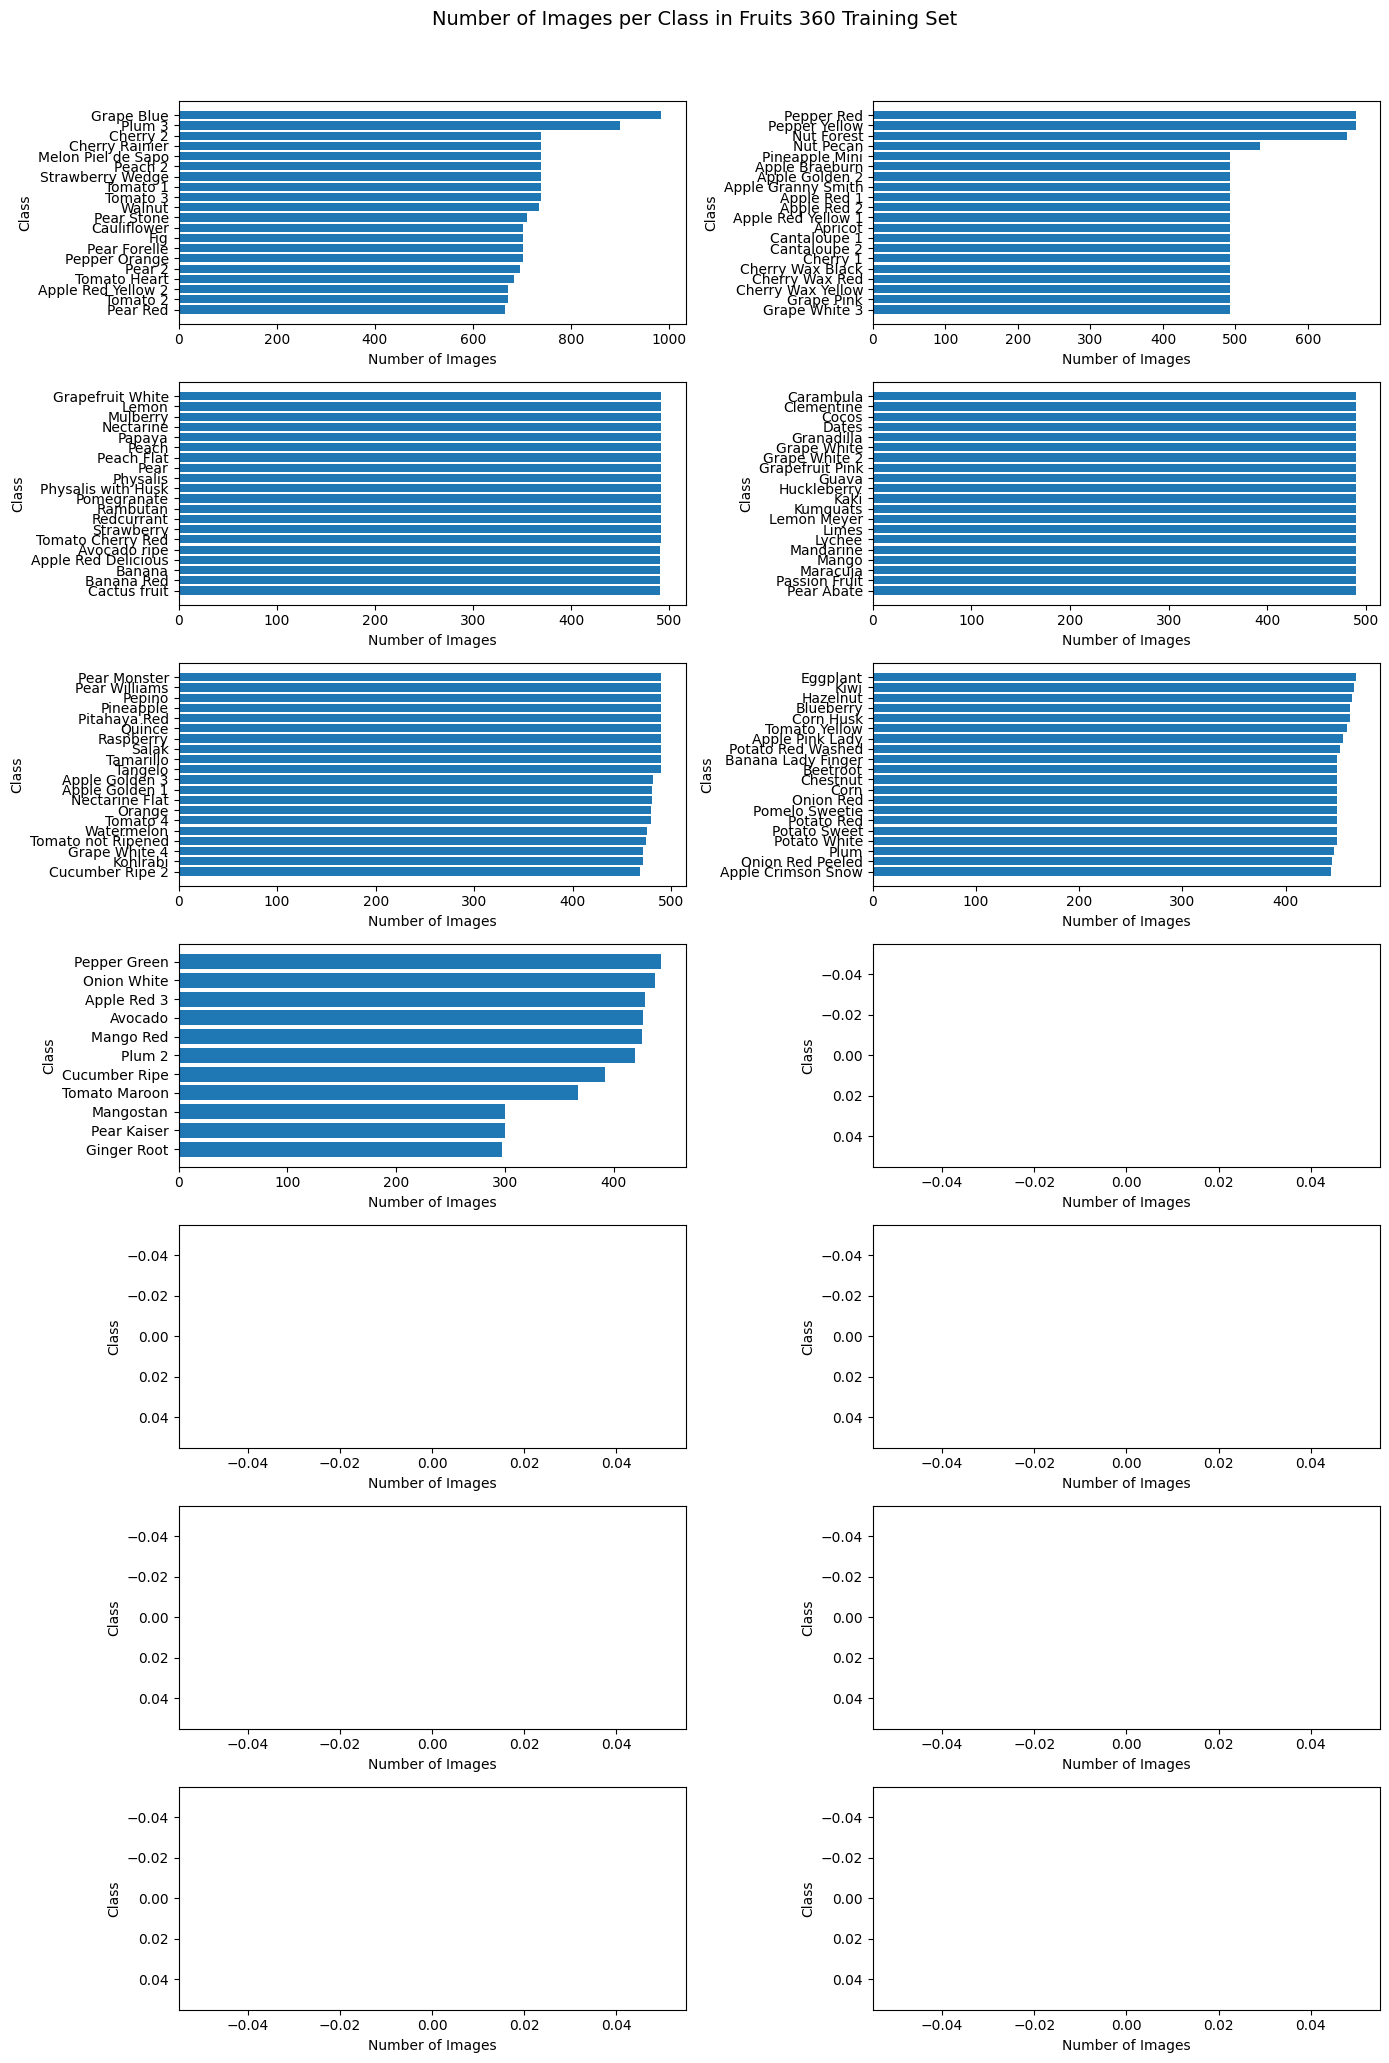

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import datasets
import math

# Load the training dataset
train_dir = "Fruit-Images-Dataset/Training"
train_dataset = datasets.ImageFolder(root=train_dir)

# Count occurrences of each class
class_counts = Counter([label for _, label in train_dataset.samples])

# Get class names and sort them by count
class_names = train_dataset.classes
class_labels = [class_names[i] for i in class_counts.keys()]
image_counts = list(class_counts.values())

# Sort for better visualization
sorted_indices = sorted(range(len(image_counts)), key=lambda k: image_counts[k], reverse=True)
sorted_labels = [class_labels[i] for i in sorted_indices]
sorted_counts = [image_counts[i] for i in sorted_indices]

# Number of subplots (adjust to fit all classes)
num_classes = len(sorted_labels)
rows = math.ceil(num_classes / 20)  # Max 20 classes per column
cols = 2  # 2-column layout for better spacing

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 3))  # Adjust height dynamically
fig.suptitle("Number of Images per Class in Fruits 360 Training Set", fontsize=14)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each group separately
for i in range(rows * cols):
    if i < num_classes:
        axes[i].barh(sorted_labels[i * 20:(i + 1) * 20], sorted_counts[i * 20:(i + 1) * 20])
        axes[i].set_xlabel("Number of Images")
        axes[i].set_ylabel("Class")
        axes[i].invert_yaxis()  # Largest at the top
    else:
        axes[i].axis("off")  # Hide unused subplots

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Training the CNN...
Epoch 1/20 | Loss: 1.5731 | Acc: 44.98%
Epoch 2/20 | Loss: 1.2394 | Acc: 57.09%
Epoch 3/20 | Loss: 1.1406 | Acc: 60.54%
Epoch 4/20 | Loss: 1.0716 | Acc: 63.06%
Epoch 5/20 | Loss: 1.0226 | Acc: 64.93%
Epoch 6/20 | Loss: 0.9858 | Acc: 65.98%
Epoch 7/20 | Loss: 0.9550 | Acc: 67.19%
Epoch 8/20 | Loss: 0.9336 | Acc: 67.71%
Epoch 9/20 | Loss: 0.9169 | Acc: 68.55%
Epoch 10/20 | Loss: 0.8932 | Acc: 69.46%
Epoch 11/20 | Loss: 0.8805 | Acc: 69.72%
Epoch 12/20 | Loss: 0.8716 | Acc: 70.15%
Epoch 13/20 | Loss: 0.8511 | Acc: 70.79%
Epoch 14/20 | Loss: 0.8417 | Acc: 71.06%
Epoch 15/20 | Loss: 0.8303 | Acc: 71.55%
Epoch 16/20 | Loss: 0.8232 | Acc: 71.83%
Epoch 17/20 | Loss: 0.8173 | Acc: 72.07%
Epoch 18/20 | Loss: 0.8074 | Acc: 72.23%
Epoch 19/20 | Loss: 0.7940 | Acc: 72.64%
Epoch 20/20 | Loss: 0.7849 | Acc: 72.90%
Training done.
Overall Test Accuracy: 74.47%
Accuracy for class 'airplane': 81.60%  (816/1000

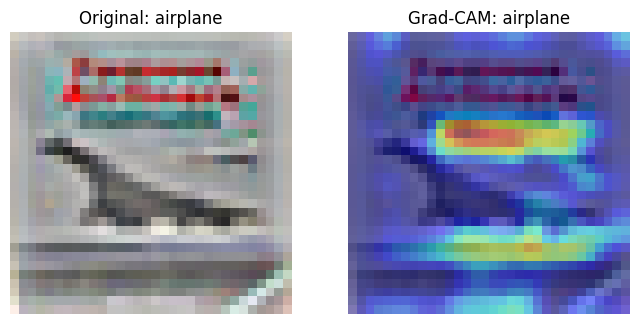

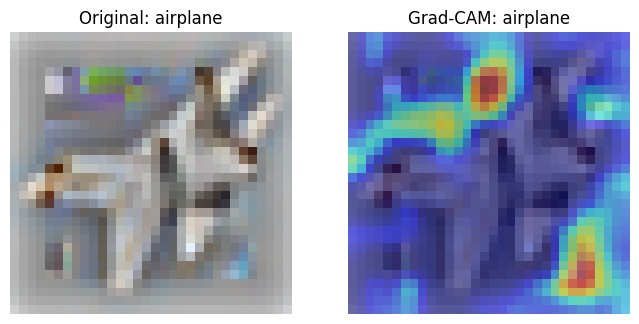

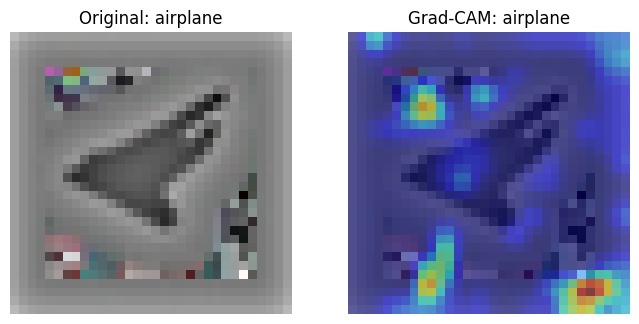

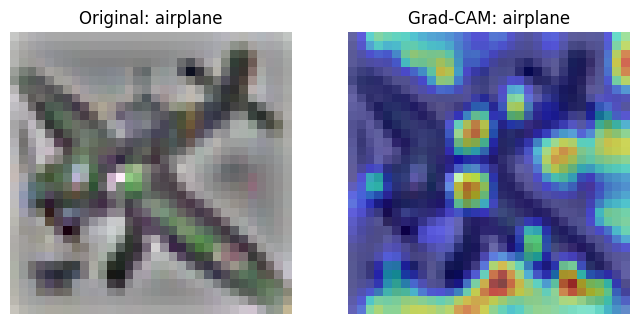

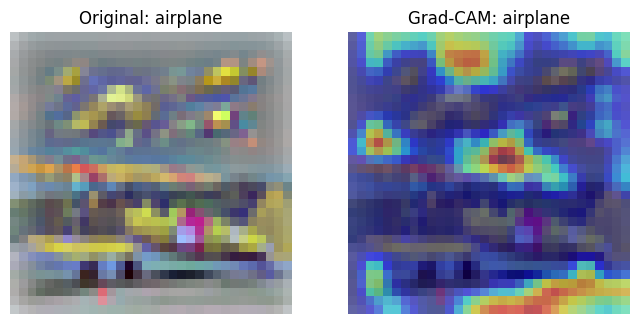

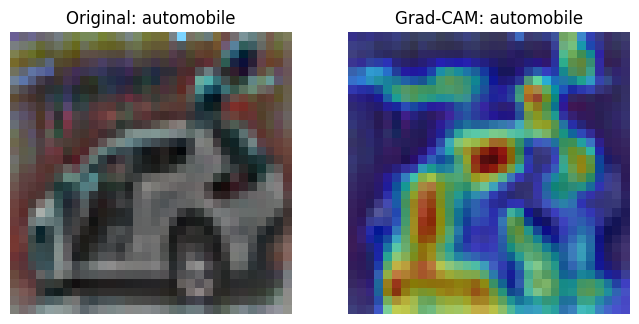

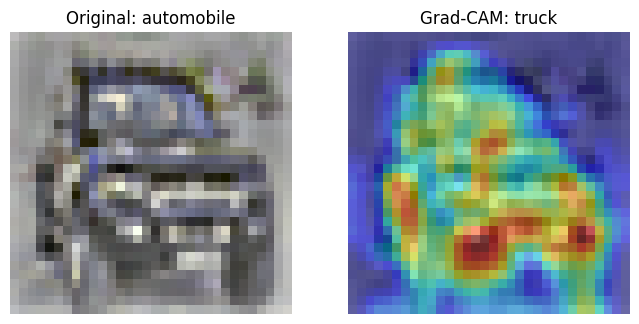

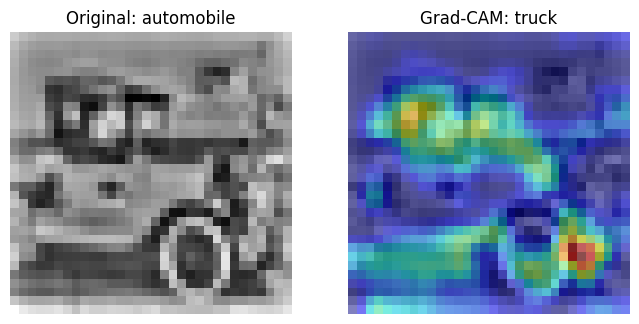

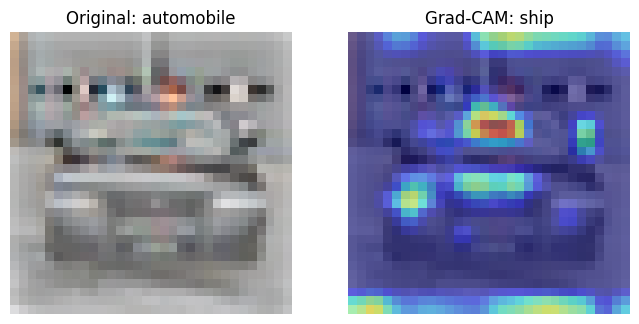

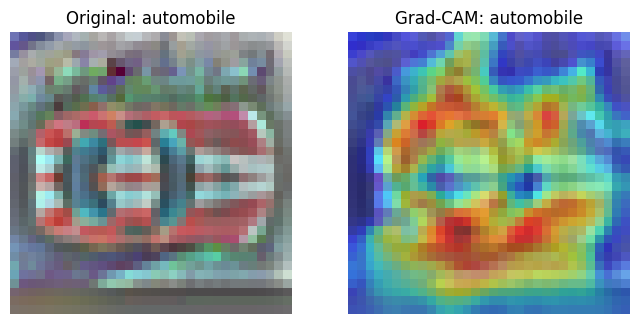

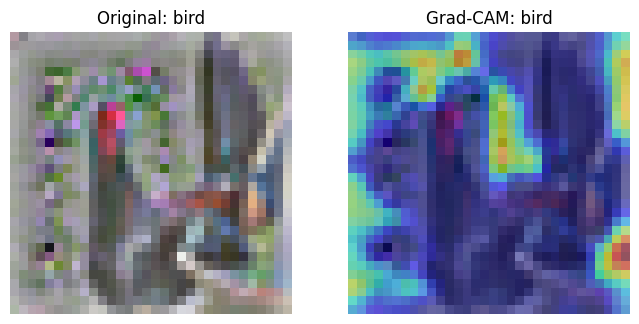

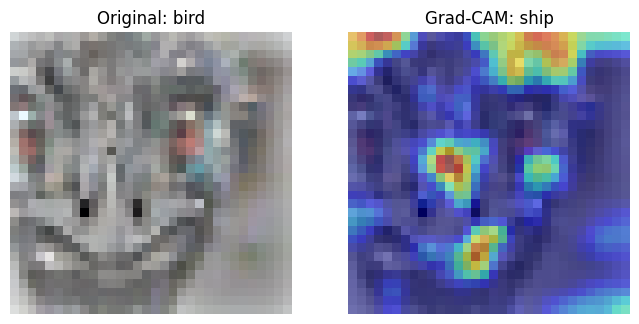

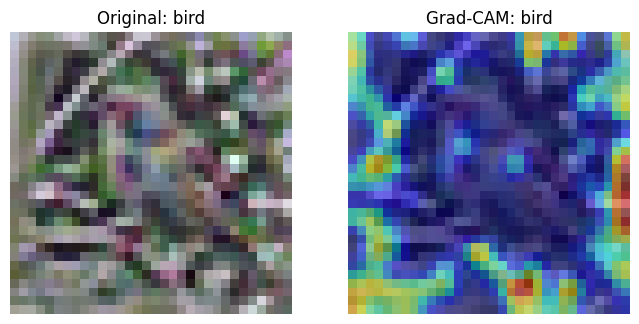

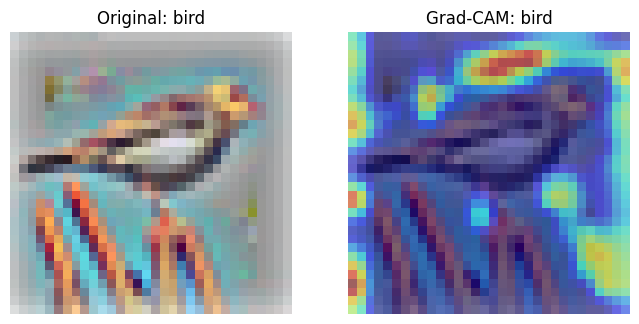

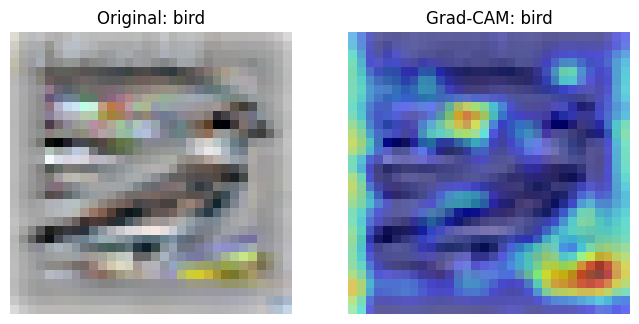

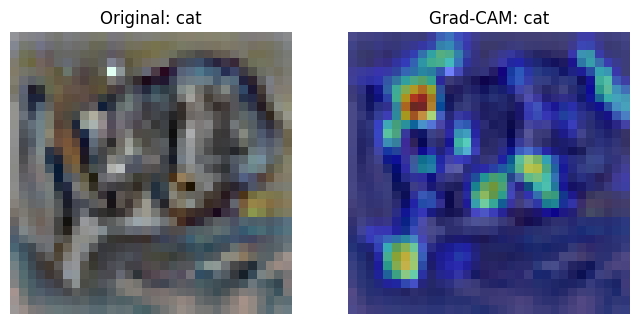

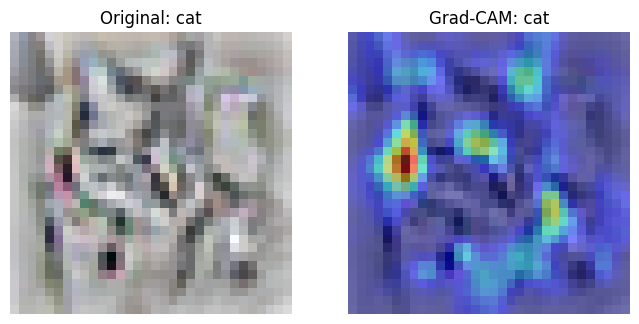

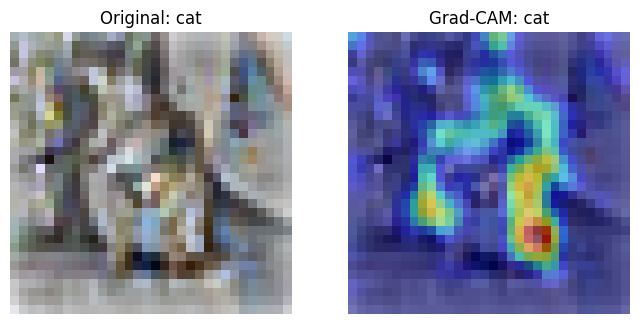

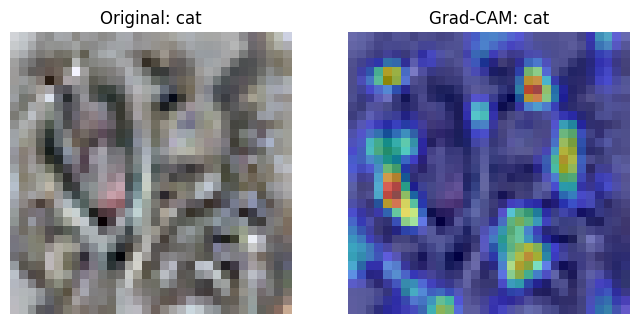

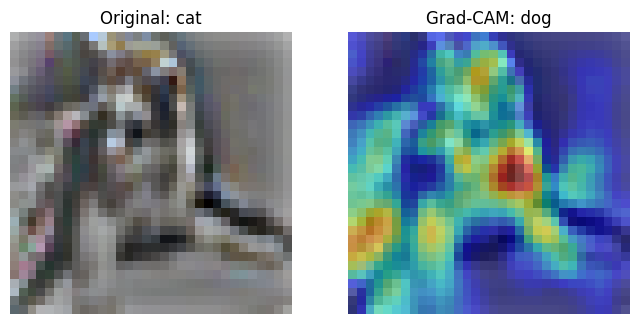

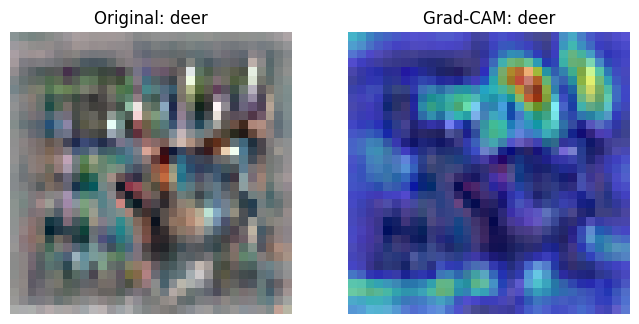

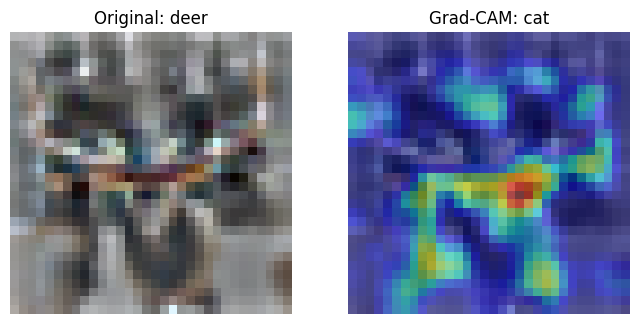

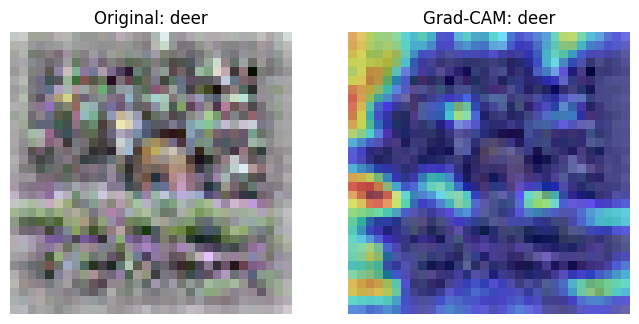

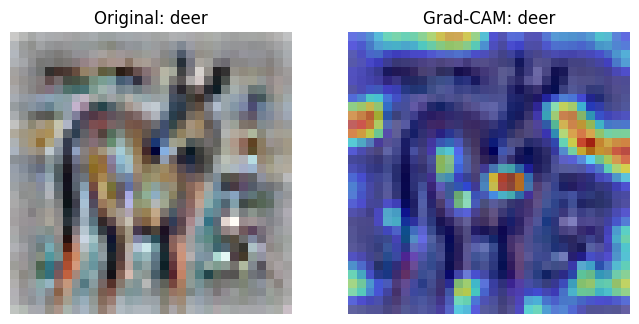

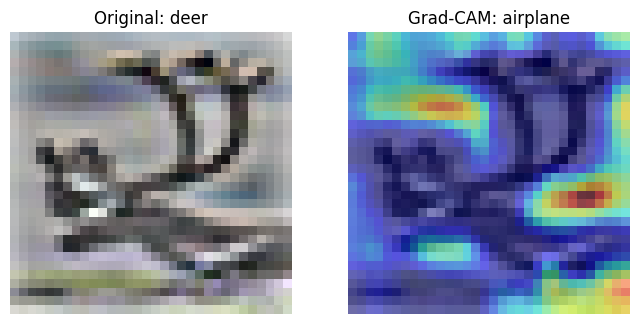

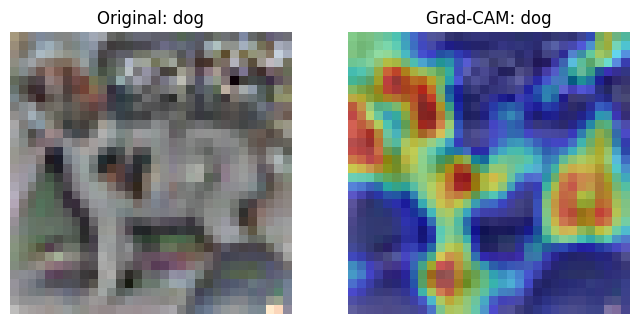

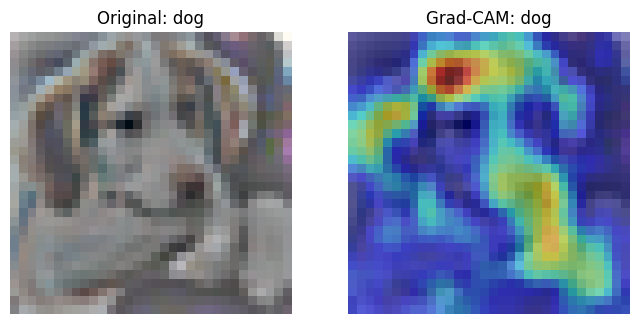

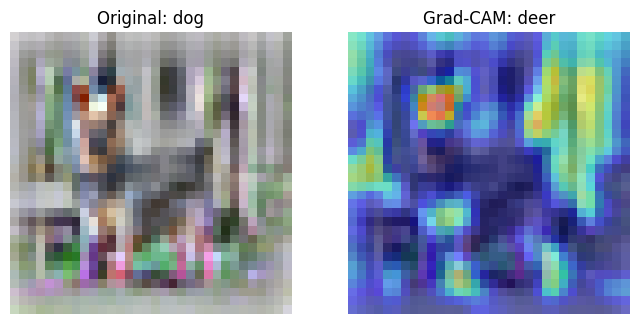

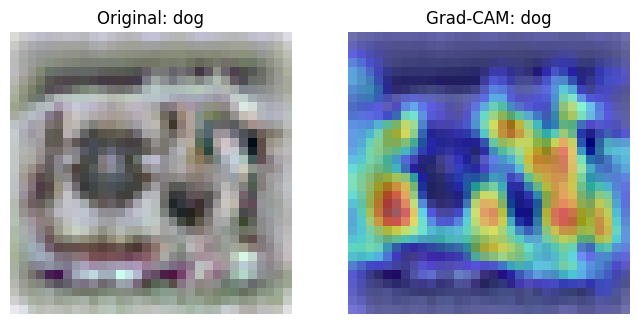

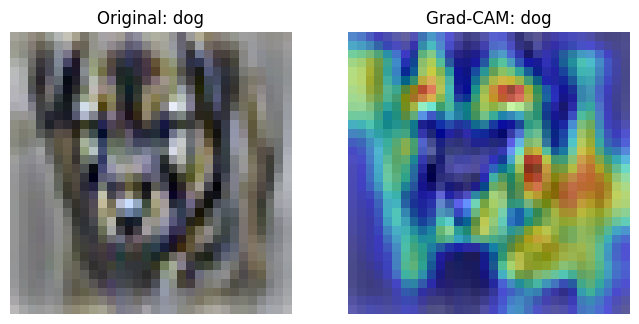

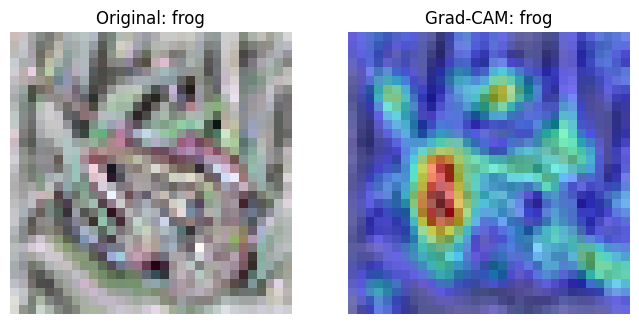

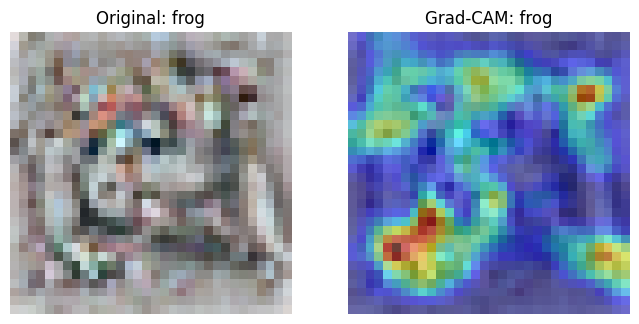

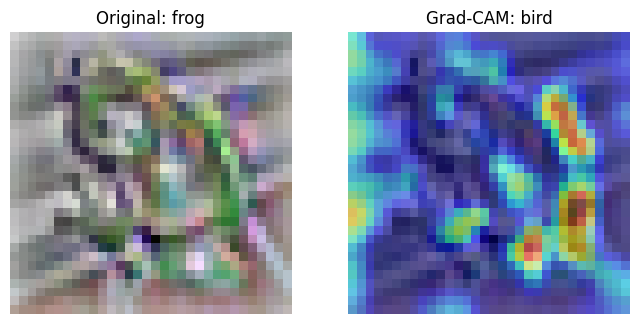

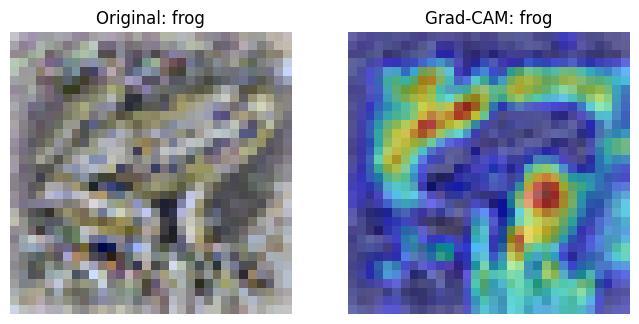

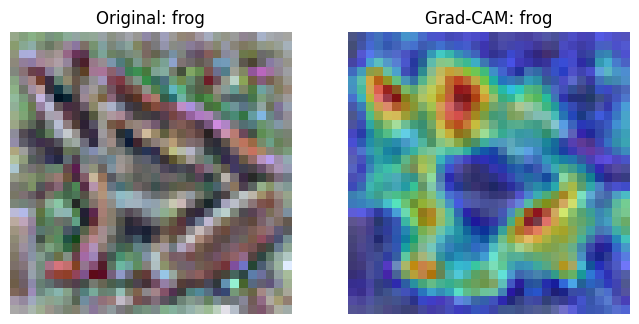

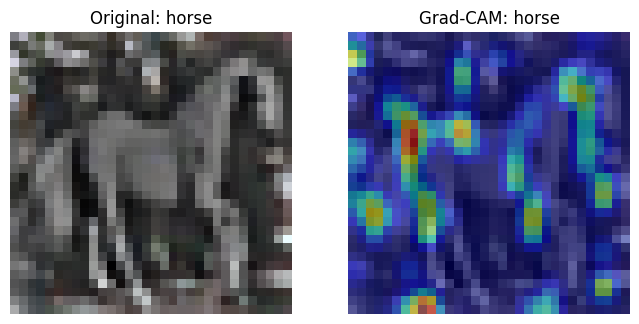

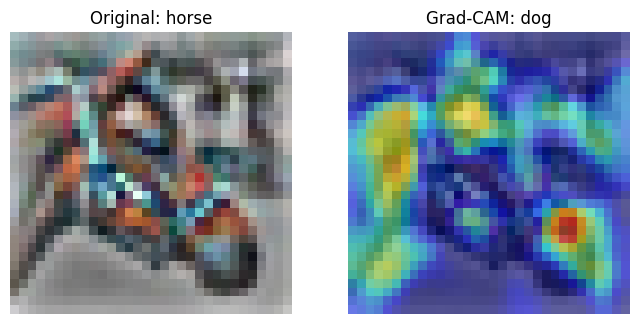

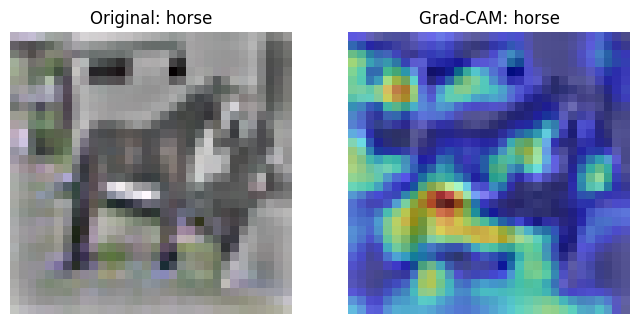

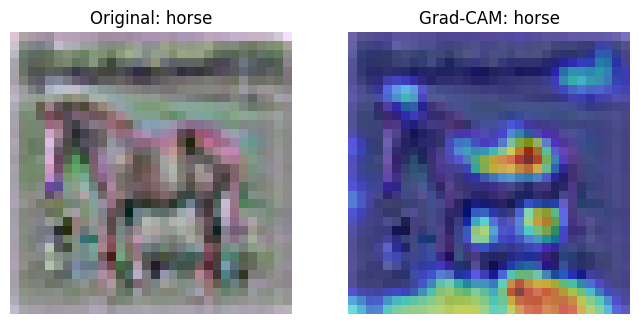

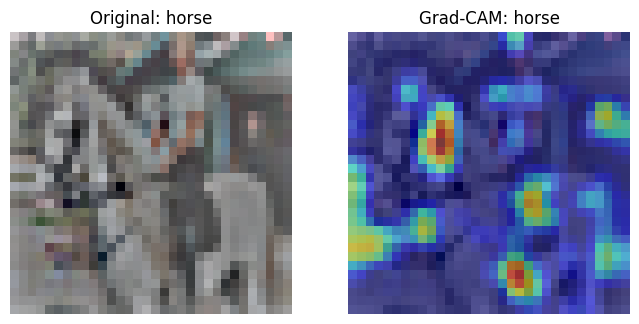

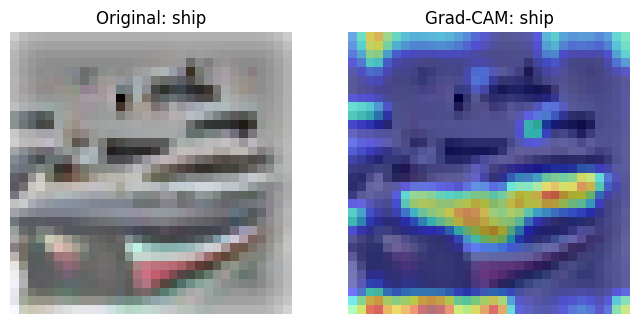

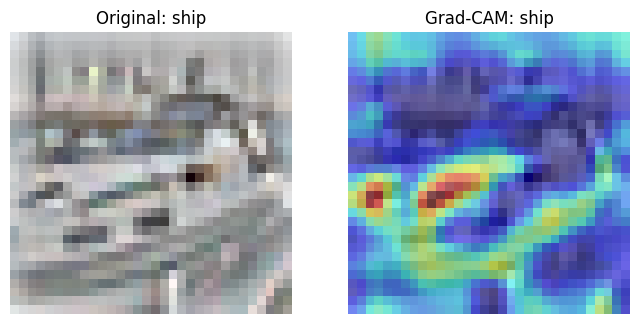

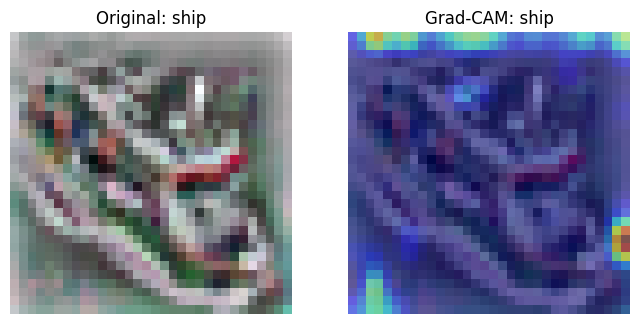

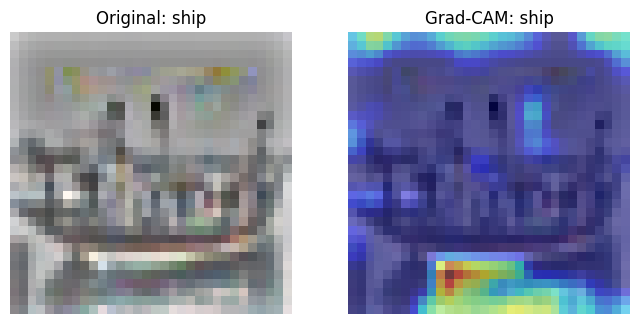

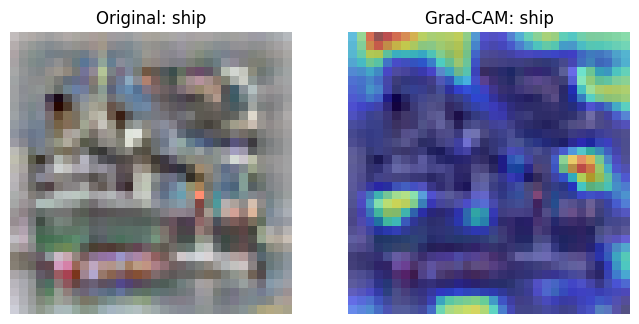

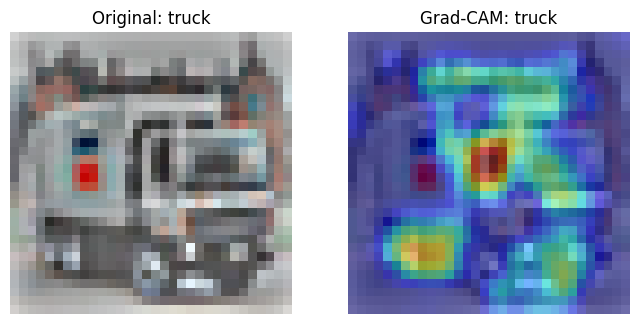

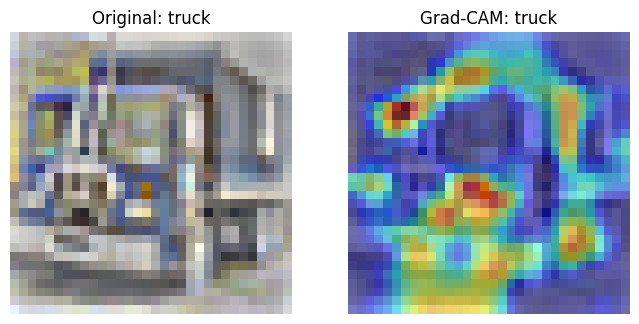

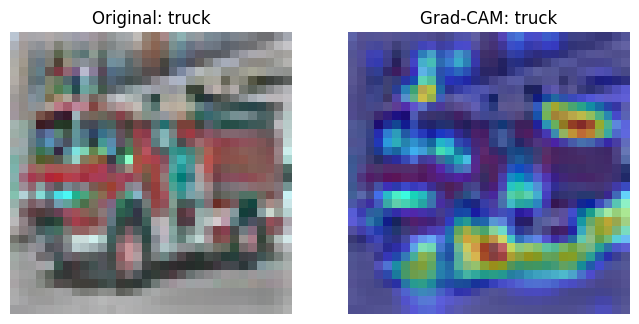

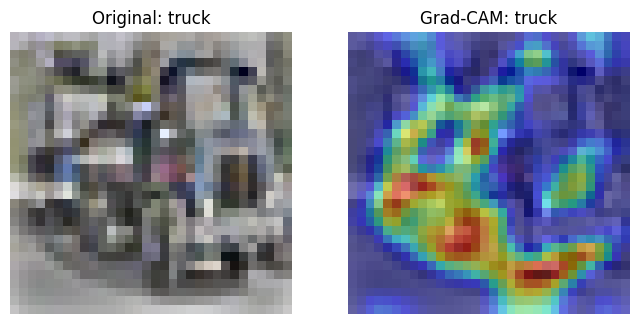

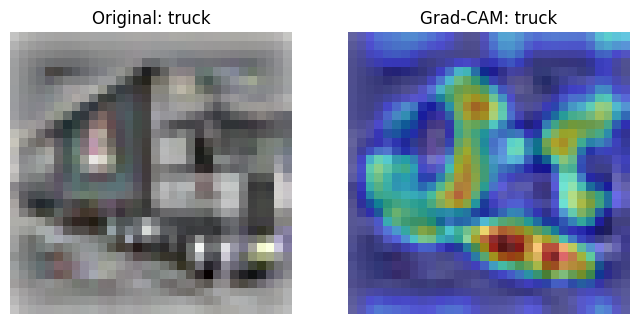

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

# For datasets and data loading
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# For numeric stability, etc.
torch.set_default_dtype(torch.float32)

#####################################################################
#                 Local Contrast Normalization (LCN)                #
#####################################################################
class LocalContrastNormalizationTransform:
    """
    Same transform as used in the CKN code: normalizes local patches
    to have zero mean and unit standard deviation.
    """
    def __init__(self, kernel_size=9, sigma=2.0, eps=1e-8):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.eps = eps
        self.kernel_2d = self._create_gaussian_kernel_2d(kernel_size, sigma)

    def _create_gaussian_kernel_2d(self, ksize, sigma):
        ax = torch.arange(ksize).float() - (ksize - 1) / 2.0
        xx = ax.repeat(ksize, 1)
        yy = xx.t()
        kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
        kernel /= kernel.sum()
        return kernel.view(1, 1, ksize, ksize)

    def __call__(self, img):
        """
        Expects 'img' to be a tensor of shape (C, H, W).
        """
        if img.dim() != 3:
            raise ValueError("Input tensor must have shape (C, H, W).")

        C, H, W = img.shape
        img = img.unsqueeze(0)  # (1, C, H, W)

        # We'll create a kernel for each channel
        kernel = self.kernel_2d.expand(C, 1, self.kernel_size, self.kernel_size)

        local_mean = F.conv2d(img, kernel, padding=self.kernel_size // 2, groups=C)
        local_mean_sq = F.conv2d(img * img, kernel, padding=self.kernel_size // 2, groups=C)

        local_var = local_mean_sq - local_mean * local_mean
        local_var = torch.clamp(local_var, min=0.0)
        local_std = torch.sqrt(local_var + self.eps)

        normalized = (img - local_mean) / local_std
        normalized = normalized.squeeze(0)
        return normalized

#####################################################################
#                     Example CNN Architecture                      #
#####################################################################
class SimpleCNN(nn.Module):
    """
    A simple CNN with two convolution layers and two pooling layers,
    then a final fully-connected layer. We'll store the output
    of the last conv layer in self.feature_maps for CAM.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        # Convolution block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16

        # Convolution block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16 -> 8x8

        # Final classifier layer
        self.classifier = nn.Linear(64 * 8 * 8, num_classes)

        # For CAM:
        self.feature_maps = None
        self.fc = self.classifier  # so we can reference model.fc.weight

    def forward(self, x):
        # First conv/pool block
        x = self.conv1(x)     # (B, 32, 32, 32)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)     # (B, 32, 16, 16)

        # Second conv/pool block
        x = self.conv2(x)     # (B, 64, 16, 16)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)     # (B, 64, 8, 8)

        # Save feature maps for Grad-CAM or "linear CAM"
        self.feature_maps = x  # shape: (B, 64, 8, 8)

        # Flatten for the final classification
        x = x.view(x.size(0), -1)  # (B, 64*8*8)
        x = self.classifier(x)     # (B, num_classes)
        return x

#####################################################################
#                     Grad-CAM Implementation                       #
#####################################################################
def compute_gradcam(model, images, target_classes, device):
    """
    Same Grad-CAM approach as in the CKN code, but now for our SimpleCNN.
    """
    model.eval()

    # For storing the forward pass (feature maps) and the gradients
    conv_activations = []
    conv_gradients = []

    # Forward hook: capture the output of the final conv layer
    def forward_hook(module, inp, out):
        conv_activations.append(out)

    # Backward hook: capture grad w.r.t. the output of the final conv layer
    def backward_hook(module, grad_in, grad_out):
        conv_gradients.append(grad_out[0])

    # Register hooks on the final conv layer (conv2 in our case).
    # But in this example, we want the "output" of the second pooling (pool2),
    # which is effectively the last feature map. We'll attach to pool2's input hook or conv2's output.
    #
    # Easiest is hooking `model.conv2` or hooking `model.pool2`.
    # We'll do it on conv2 for clarity.
    handle_f = model.conv2.register_forward_hook(forward_hook)
    handle_b = model.conv2.register_backward_hook(backward_hook)

    # Forward pass
    outputs = model(images)

    # We gather the relevant class scores from 'outputs'
    selected_scores = outputs.gather(1, target_classes.view(-1, 1)).squeeze()

    # Backward pass
    model.zero_grad()
    selected_scores.sum().backward(retain_graph=True)

    # Remove hooks
    handle_f.remove()
    handle_b.remove()

    # Retrieve the stored activations and gradients
    activations = conv_activations[0]   # (B, 64, H, W)
    gradients   = conv_gradients[0]     # (B, 64, H, W)
    B, C, H, W = activations.shape

    # Compute per-channel weights by averaging the gradients spatially
    alpha = gradients.view(B, C, -1).mean(dim=2)  # (B, 64)

    # Weighted sum of activations
    cams = torch.zeros((B, H, W), device=device, dtype=activations.dtype)
    for i in range(B):
        cam_raw = (activations[i] * alpha[i].view(C, 1, 1)).sum(dim=0)
        cam_relu = F.relu(cam_raw)

        # Normalize to [0,1]
        cam_min, cam_max = cam_relu.min(), cam_relu.max()
        cam_norm = (cam_relu - cam_min) / (cam_max - cam_min + 1e-8)
        cams[i] = cam_norm

    return cams  # (B, H, W)

def overlay_gradcam_on_image(model, images, labels, class_names, device):
    """
    Same overlay function as in the CKN code, adapted to our SimpleCNN.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    # Compute Grad-CAM for each predicted class
    cams = compute_gradcam(model, images, predicted, device)  # shape (B, H', W')

    # We need to upsample from (H', W') to the input resolution (32x32)
    B, Hf, Wf = cams.shape
    images_np = images.cpu().numpy()
    cams_np = cams.detach().cpu().numpy()

    # Original input resolution from the batch
    _, _, H_in, W_in = images.shape

    for i in range(B):
        cam = cams_np[i]
        # Convert to [0,1] just to be safe
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        # Resize CAM to match input resolution
        cam_img = Image.fromarray(cam).resize((W_in, H_in), Image.BILINEAR)
        cam_img = np.array(cam_img)

        # Original image as [0,1]
        img = images_np[i]
        img = np.transpose(img, (1, 2, 0))  # (C,H,W) -> (H,W,C)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Original: {class_names[labels[i].item()]}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.imshow(cam_img, cmap='jet', alpha=0.5)
        plt.title(f'Grad-CAM: {class_names[predicted[i].item()]}')
        plt.axis('off')
        plt.show()

def plot_specific_images_gradcam(model, dataset, indices, class_names, device):
    """
    Gathers specific images from the dataset into a batch, then calls overlay_gradcam_on_image.
    """
    model.eval()
    images = []
    labels = []
    for idx in indices:
        image, label = dataset[idx]
        images.append(image)
        labels.append(label)

    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    overlay_gradcam_on_image(model, images, labels, class_names, device)

def get_first_k_indices_per_class(dataset, k=5):
    """
    Returns a list of indices with the first `k` examples from each class in `dataset`.
    Assumes the dataset returns (image, label) and that labels are from 0..9 (10 classes).
    """
    # Prepare a list of lists to store indices for each of the 10 classes
    class_indices = [[] for _ in range(10)]

    # Loop over the dataset until we've collected k items for each of the 10 classes
    for idx, (image, label) in enumerate(dataset):
        if len(class_indices[label]) < k:
            class_indices[label].append(idx)
        # Check if we've got k items for every class
        if all(len(lst) == k for lst in class_indices):
            break

    # Flatten into a single list of indices
    # If you want to preserve class grouping, you can keep them separate
    all_indices = []
    for lst in class_indices:
        all_indices.extend(lst)

    return all_indices


#####################################################################
#                           Main Script                             #
#####################################################################
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = 128
    epochs = 20  # fewer epochs for demonstration
    num_classes = 10

    ###################################################################
    # 1) Data transforms: same as in the CKN code
    ###################################################################
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        LocalContrastNormalizationTransform(kernel_size=9, sigma=2.0, eps=1e-8)
    ])

    ###################################################################
    # 2) Data loading
    ###################################################################
    cifar_train = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform_train)
    cifar_test  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True,  num_workers=2)
    test_loader  = DataLoader(cifar_test,  batch_size=batch_size, shuffle=False, num_workers=2)

    class_names = cifar_train.classes  # e.g. ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    ###################################################################
    # 3) Build and train the CNN
    ###################################################################
    model = SimpleCNN(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("Training the CNN...")
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += imgs.size(0)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Loss: {total_loss/total:.4f} | "
              f"Acc: {100.0 * correct / total:.2f}%")

    print("Training done.")

    ###################################################################
    # 4) Evaluate on test set
    ###################################################################
    # Evaluate on test set and also compute per-class accuracy
    model.eval()
    correct = 0
    total = 0

    num_classes = 10
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)

            # Overall accuracy
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Per-class accuracy: tally counts
            for i in range(labels.size(0)):
                label_i = labels[i].item()
                pred_i = predicted[i].item()
                if pred_i == label_i:
                    class_correct[label_i] += 1
                class_total[label_i] += 1

    test_accuracy = 100.0 * correct / total
    print(f"Overall Test Accuracy: {test_accuracy:.2f}%")

    # Print accuracy for each class
    class_names = cifar_train.classes  # ['airplane', 'automobile', 'bird', ...] in CIFAR-10
    for i, cls_name in enumerate(class_names):
        if class_total[i] == 0:
            acc_i = 0  # just to avoid division by zero
        else:
            acc_i = 100.0 * class_correct[i] / class_total[i]
        print(f"Accuracy for class '{cls_name}': {acc_i:.2f}%  "
              f"({class_correct[i]}/{class_total[i]})")

    # 1) Collect the first 5 indices from each class in the test set
    chosen_indices = get_first_k_indices_per_class(cifar_test, k=5)

    # 2) Plot them with Grad-CAM
    plot_specific_images_gradcam(model, cifar_test, chosen_indices, class_names, device)



if __name__ == "__main__":
    main()
